# Basic imports and and data reading

In [1]:
import scipy.io
from scipy import stats
import numpy as np  
import matplotlib.pyplot as plt 
%matplotlib inline 

np.random.seed(1111111) # para poder replicar los resultados

In [2]:
path = 'C:/Users/lucia/Desktop/OriginalDataEPFL/'
# path = './data/' If downloading the repository descomment this line and comment the previous one

subjects = ['subject1/','subject2/','subject3/','subject4/','subject6/','subject7/','subject8/','subject9/']
sessions = ['s1.mat','s2.mat','s3.mat','s4.mat']

su_1 = []
su_2 = []
su_3 = []
su_4 = []
su_6 = []
su_7 = []
su_8 = []
su_9 = []

data = [su_1, su_2, su_3, su_4, su_6, su_7, su_8, su_9]

for subject_path, subject in zip(subjects, data):
    for session in sessions:
        subject.append(scipy.io.loadmat(path + subject_path  + session))

In [3]:
su_1[0].keys()

dict_keys(['__header__', '__version__', '__globals__', 'runs'])

In [7]:
electrode_list = ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4','P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz']

# Data exploration

### su_n is a list formed by multidimensionales arrays :

- Each list has 4 entries, one for each session:
```
len(su_i) = 4
``` 

- With the second index we iterate over the 6 runs of each session:
```
su_i[0]['runs'][0,i]
``` 

With i  $\epsilon$ [0,5]

- Then we need two more indexed which are [0,0] to get rid of the last part of information talking about the array's structure:
```
su_1[0]['runs'][0,1][0,0]
``` 

- After this we get an array formed by:
    - Signal amplitude
    
    ```
    su_1[0]['runs'][0,i][0,0][0] = array([[[ 3.66999613e+00,  4.83541847e-01,  2.44269762e+00, ...,]]]) 
    su_1[0]['runs'][0,i][0,0][0].shape = (32, 128, 144)
    ```
   
    - Hits/Misses respecting the image that the subject is thinking about
    
    ```
    su_1[0]['runs'][0,1][0,0][1][0] = array([-1, -1, 1,..., -1, -1])
    su_1[0]['runs'][0,1][0,0][1][0].shape = (144,)
    ```
    
    1 &rarr; The image is a hit <br>
    \-1 &rarr; The image is a miss <br><br>

    - Sequence of the presented images
    
    ```
    su_1[0]['runs'][0,1][0,0][2][0] = array([1, 6, 2, 5,..., 4, 5])
    su_1[0]['runs'][0,1][0,0][2][1].shape = (144,)
    ```
    
    - Target image of the run
    
    ```
    su_1[0]['runs'][0,1][0,0][3][0] = array([2])
    su_1[0]['runs'][0,1][0,0][3][0].shape = (1,)
    ```
The last [0] is to unpack the remaining array: [[1,2,3,4]] instead of [1,2,3,4].

# Data cleaning

We decided to create a simpler structure of the data.

Also we take only the 120 first images of every season and offer a possibility of resampling to 32 Hz.

In [5]:
def data_cleaning(subject_data, sampling=128):
    """
    Function which takes the subject data and simplifies it making it easier to work with. Offers the possibility to resample
    to 32 Hz instead of 128.
    
    Args:
        subject_data: Multidimensional array containing the subject's data. Structure explained above.
        sampling: Sampling ratio desired. By the default 128 Hz.
        
    Returns:
        subject: List formed of multimensional arrays containing a sanitized data
    """

    subject = []
    
    for session in subject_data:
        sesion = []
        for run in range(6):
            
            if sampling==128:
                a = session['runs'][0,run][0,0][0][:,:,:120]
            else:
                ratio = int(128/sampling)
                a = session['runs'][0,run][0,0][0][:,::ratio,:120]
                
            b = session['runs'][0,run][0,0][1][0][:120]
            c = session['runs'][0,run][0,0][2][0][:120]
            d = session['runs'][0,run][0,0][3][0]

            run = {'eeg': a, 'check':b , 'img': c, 'target': d}

            sesion.append(run)
        subject.append(sesion)
    return subject

We created a variation with resampling to 32 Hz and normalizing using z-score.

In [6]:
su_1_clean = data_cleaning(su_1)
su_2_clean = data_cleaning(su_2)
su_3_clean = data_cleaning(su_3)
su_4_clean = data_cleaning(su_4)
su_6_clean = data_cleaning(su_6)
su_7_clean = data_cleaning(su_7)
su_8_clean = data_cleaning(su_8)
su_9_clean = data_cleaning(su_9)

Each list has the data of a subject:
 
- First index gives us the session (1-4)
- Second index gives the run (1-6)
- Each run is a dictionary with 4 entries:
    - eeg: Electroencefalogram for each of the 32 electrodes, for one of the 120 images
    - img: Sequence of shown images
    - check: Hits/Misses respecting the image that the subject is thinking about
    - target: Target image of the run

In [7]:
su_1_clean[0][0].keys()

dict_keys(['eeg', 'check', 'img', 'target'])

### Ensuring that the cleaning function don't altere the data unexpectedly

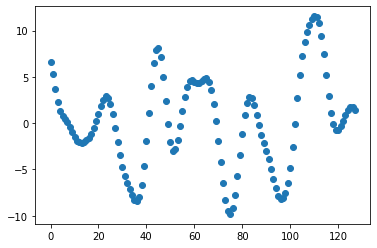

In [8]:
plt.scatter(range(su_1[0]['runs'][0,0][0,0][0][0][:,0].shape[0]),su_1[0]['runs'][0,0][0,0][0][0][:,0])
plt.show()

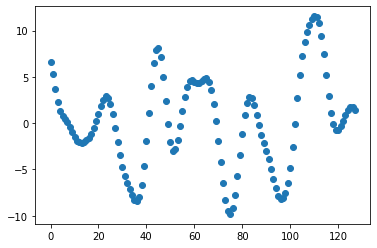

In [9]:
plt.scatter(range(su_1_clean[0][0]['eeg'][0][:,0].shape[0]),su_1_clean[0][0]['eeg'][0][:,0])
plt.show()

# Showing some data to understand the problem

We define some functions that will helps us to present the data

In [7]:
def two_trial_comparison(trial_1, trial_2):
    
    """
    Gets the position of the first array where the overlap with the second one starts and return the values of the first one
    that dont overlap
    
    Args:
        trial_1: Array n_electrodes X n_points dimensional
        trial_2: Array n_electrodes X n_points dimensional
        
    Returns:
        non_overlapping_array: Array with values of the first one that dont overlap with the second
    """
    
    coincidence_pos = np.where(trial_2[0][0] == trial_1[0])[0][0]
    non_overlapping_array = trial_1[:,:coincidence_pos]

    return non_overlapping_array

def combine_in_blocks_of_six_images(run_eeg):
    
    """
    Transforms the individual trials in blocks of 6 images concatenating the non-overlapping parts of them
    
    Args:
        run_eeg: Array n_electrodes X n_points_per_trail X n_trials dimensional
        
    Returns:
        run_blocks: List with one entry per block of 6 images, entries are arrays n_electrodes X n_points_per_block dimensional
    """
    
    run_blocks = []
    
    for i in range(int(run_eeg.shape[2] / 6)):                 # n trials (120) divided by 6 -> 0-19
        
        block = []
        for j in range(6*i,6*i+4):                             # 0-4, 6-10
            
            trial_1 = run_eeg[:,:,j]
            trial_2 = run_eeg[:,:,j+1]
            
            non_overlapping = two_trial_comparison(trial_1, trial_2)
            block.append(non_overlapping)
            
        block.append(trial_2)        # Appending the full 5th trail of the block
        block = np.concatenate((
            block[0][:], block[1][:],block[2][:],block[3][:],block[4][:]),axis=1) # Concatenating arrays to give easier shape
        
        run_blocks.append(block)     # Append each of the 20 blocks generated

    return run_blocks

## Block of 6 images with clear response

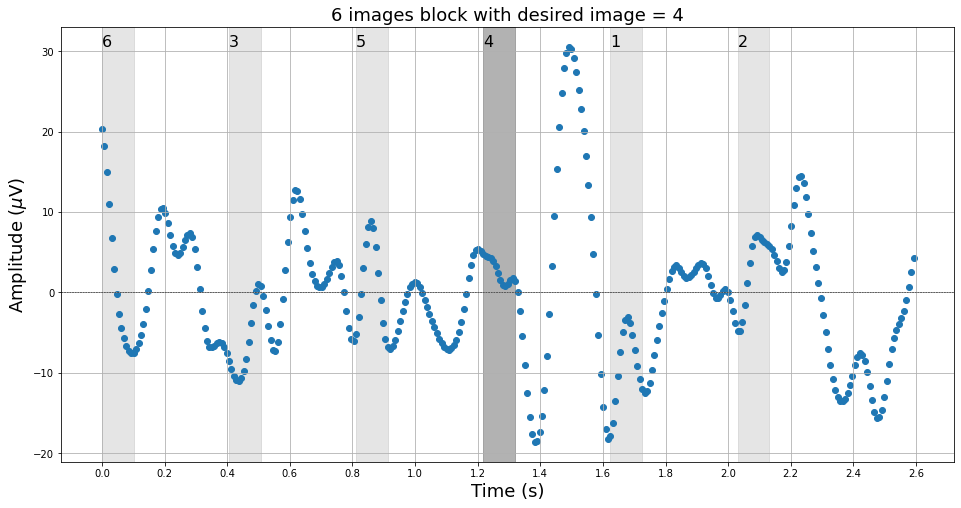

In [9]:
six_image_block = combine_in_blocks_of_six_images(su_1_clean[0][1]['eeg'])

image_sequence = su_1_clean[0][1]['img'][:6]
desired_image = su_1_clean[0][1]['target'][0]

font = {'size': 18}
HUNDRED_MS = int(su_1_clean[0][1]['eeg'].shape[1] / 9.8)

fig, ax = plt.subplots(figsize=(16,8))
ax.set_title('6 images block with desired image = {}'.format(desired_image), fontdict=font)
ax.axhline(y=0, color='black', ls='--', lw=0.5)
ax.grid()
plt.xlabel('Time (s)',fontdict=font)
plt.ylabel(r'Amplitude ($\mu$V)',fontdict=font)
plt.xticks(np.arange(0,2.8,0.2))


x = np.array(range(len(six_image_block[0][0]))) / (len(six_image_block[0][0])) * 2.6
y = six_image_block[0][0]

for i, img in enumerate(image_sequence):
    
    ax.text(x=x[4*i*HUNDRED_MS], y=max(y), s=str(img), size='16')
    
    if img == desired_image:
        plt.axvspan(x[4*HUNDRED_MS*i], x[4*HUNDRED_MS*i+HUNDRED_MS], color='grey', alpha=0.6)
    else:
        plt.axvspan(x[4*HUNDRED_MS*i], x[4*HUNDRED_MS*i+HUNDRED_MS], color='grey', alpha=0.2)
    
plt.scatter(x,y)
plt.show()

## Block of 6 images with unclear response

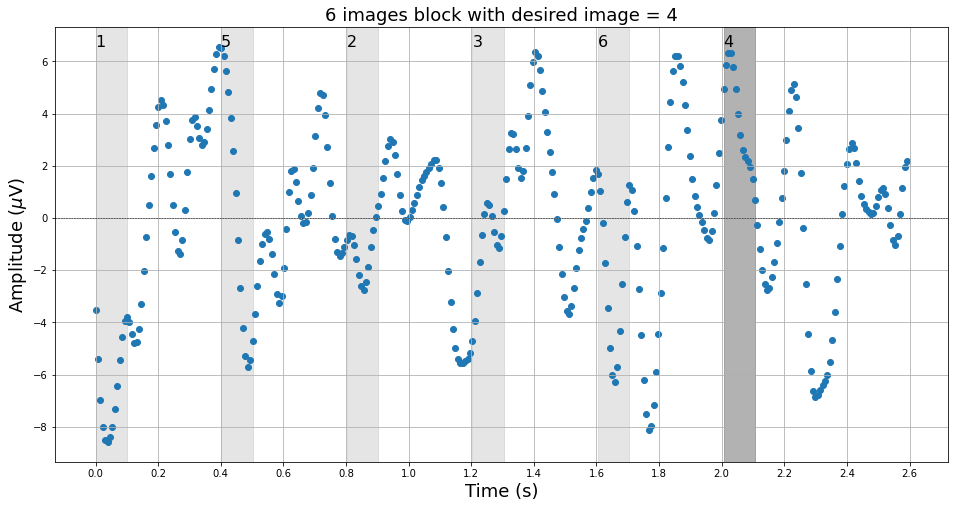

In [12]:
six_image_block = combine_in_blocks_of_six_images(su_6_clean[0][1]['eeg'])

image_sequence = su_6_clean[0][1]['img'][:6]
desired_image = su_6_clean[0][1]['target'][0]

font = {'size': 18}
HUNDRED_MS = int(su_1_clean[0][1]['eeg'].shape[1] / 9.8)

fig, ax = plt.subplots(figsize=(16,8))
ax.set_title('6 images block with desired image = {}'.format(desired_image), fontdict=font)
ax.axhline(y=0, color='black', ls='--', lw=0.5)
ax.grid()
plt.xlabel('Time (s)',fontdict=font)
plt.ylabel(r'Amplitude ($\mu$V)',fontdict=font)
plt.xticks(np.arange(0,2.8,0.2))


x = np.array(range(len(six_image_block[0][0]))) / (len(six_image_block[0][0])) * 2.6
y = six_image_block[0][0]

for i, img in enumerate(image_sequence):
    
    ax.text(x=x[4*i*HUNDRED_MS], y=max(y), s=str(img), size='16')
    
    if img == desired_image:
        plt.axvspan(x[4*HUNDRED_MS*i], x[4*HUNDRED_MS*i+HUNDRED_MS], color='grey', alpha=0.6)
    else:
        plt.axvspan(x[4*HUNDRED_MS*i], x[4*HUNDRED_MS*i+HUNDRED_MS], color='grey', alpha=0.2)
    
plt.scatter(x,y)
plt.show()

## Ilustrating the P300 window

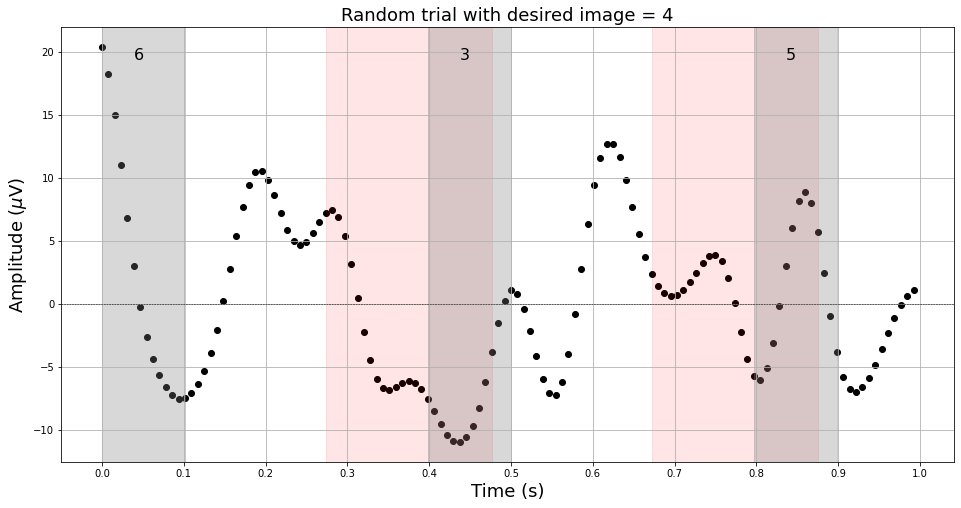

In [13]:
y = su_1[0]['runs'][0,1][0,0][0][0][:,0]
x = np.array([range(len(y))][0]) / len(y)

image_sequence = su_1[0]['runs'][0,1][0,0][2][0]
desired_image = su_1[0]['runs'][0,1][0,0][3][0][0]
HUNDRED_MS = int(su_1_clean[0][1]['eeg'].shape[1] / 9)

font = {'size': 18}

fig, ax = plt.subplots(figsize=(16,8))

ax.set_title('Random trial with desired image = {}'.format(desired_image), fontdict=font)
ax.axhline(y=0, color='black', ls='--', lw=0.5)
ax.grid()

plt.xlabel('Time (s)',fontdict=font)
plt.ylabel(r'Amplitude ($\mu$V)',fontdict=font)
plt.xticks(np.arange(0,1.2,0.1))

ax.scatter(x,y,color='black')

POS_P300 = int(len(y)/3.3)          # 300 ms
IMAGE_START = int(len(y)/2.5)       # 400 ms
HUNDRED_MS = int(len(y)/9.8)        # 100 ms

ax.axvspan(x[POS_P300-int(HUNDRED_MS/4)], x[POS_P300+int(HUNDRED_MS*1.8)], color='red', alpha=0.1)
ax.axvspan(x[IMAGE_START+POS_P300-int(HUNDRED_MS/4)], x[IMAGE_START+POS_P300+int(HUNDRED_MS*1.8)], color='red', alpha=0.1)

for i in range(3):
    
    ax.axvspan(x[i*IMAGE_START], x[i*IMAGE_START+HUNDRED_MS], color='grey', alpha=0.3)
    
    ax.text(x=x[i*IMAGE_START + int(len(y)*0.04)], y=max(y)-1, s=str(image_sequence[i]), size=16)
    
plt.show()

# Separating data in response and baseline for each run

We define some functions that will help us in the separation between target and non-target trials and in data inside the stimulus window and outside it.

In [8]:
def stimulus_baseline_window_obtainer(run_eeg, run_check, center, semi_width, size):
    """
    Function that separates the run trials in target or baseline trials and bootstraps them to get the same proportion.
    
    Args:
        run_eeg: Values of electroencefalogram of the run (n_electrodes x n_points x n_trials)
        run_check: Array n_images indicating if the image is the target the subject is thinking or not
        center: Position of the center of the stimulus window
        semi_width: Semi width of the stimulus window
        size: Numbers of separated trials desired. They are selected via bootstrapping
        
    Returns:
        target_random: List with a random selection of trials which have a target image    
        baseline_random: List with a random selection of trials which do not have a target image
    """
    
    target_random = []
    baseline_random = []
    
    for i in range(run_eeg.shape[2] - 1):
        
        if run_check[i] > 0:                   # If the image is target
            target_random.append(i)
        else:                                  # If the image isn't target
            baseline_random.append(i)
        
    target_random = np.random.choice(target_random, size=size, replace=True)      # Bootstrappping the target trials
    baseline_random = np.random.choice(baseline_random, size=size, replace=True)  # Bootstrappping the non-target trials
    
    return target_random, baseline_random

In [9]:
def mask_generator(sampling_rate, desired_length, center, semi_width):
    """
    Generates a boolean mask with True values for the stimulus window and False to the rest of the window
    
    Args:
        sampling_rate: Number of points per trial
        desired_length: Miliseconds desired from the trials
        center: Position of the center of the stimulus window
        semi_width: Semi width of the stimulus window
        
    """
    
    TRIAL_DURATION = 984.61                     # ms
    
    TRIAL_LENGTH = sampling_rate                                                 # POINTS 
    TRIAL_LENGTH_REDUCED = int(TRIAL_LENGTH * desired_length / TRIAL_DURATION)   # POINTS
    
    CENTER = int(TRIAL_LENGTH / (TRIAL_DURATION / center))
    SEMI_WIDTH  = int(TRIAL_LENGTH / (TRIAL_DURATION / semi_width))
    
    stimulus_window = np.array(range(int(CENTER - SEMI_WIDTH), int(CENTER + SEMI_WIDTH)))
    
    mask = np.zeros(TRIAL_LENGTH_REDUCED, dtype=bool)
    mask[stimulus_window[stimulus_window<TRIAL_LENGTH_REDUCED]] = True
    
    return mask

In [10]:
def response_baseline_data_separation(run_eeg, run_check, center, semi_width):
    """
    Separates the values of every trial in a run into response and baseline
    
    Args:
        run_egg: Values of electroencefalogram of the run (n_electrodes x n_points x n_trials)
        run_check: Array n_images indicating if the image is the target the subject is thinking or not
        center: Position of the center of the stimulus window
        semi_width: Semi width of the stimulus window
        
    Returns:
        response: List with n_trials entries of n_electrodes x n_points with the data where we expect response to stimulus
        baseline: List with n_trials entries of n_electrodes x n_points with the data we expect as baseline
    """
    response, baseline = [], []
    
    mask = mask_generator(128, 984.61, center, semi_width)
    
    for i in range(run_eeg.shape[2]):
        
        trial = run_eeg[:,:,i]
        stimulus_data = trial[:,mask]
        baseline_data = trial[:,~mask]
        
        response.append(stimulus_data)
        baseline.append(baseline_data)

    return response, baseline

## Obtaining the baseline / response separation for all the data

In [128]:
su_1_separated = [None]*2
su_2_separated = [None]*2
su_3_separated = [None]*2
su_4_separated = [None]*2
su_6_separated = [None]*2
su_7_separated = [None]*2
su_8_separated = [None]*2
su_9_separated = [None]*2

data = [su_1_clean, su_2_clean, su_3_clean, su_4_clean, su_6_clean, su_7_clean, su_8_clean, su_9_clean]
sep_data = [su_1_separated, su_2_separated, su_3_separated,su_4_separated, su_6_separated, su_7_separated, su_8_separated, su_9_separated]

for subject_in, subject_out in zip(data, sep_data):

    baseline_subject = []
    response_subject = []

    for sesion in subject_in:

        baseline_sesion = []
        response_sesion = []

        for run in sesion:
            
            response_run, baseline_run  = response_baseline_data_separation(run['eeg'], run['check'], 400, 50)
            
            
            baseline_sesion.append(baseline_run)
            response_sesion.append(response_run)

        baseline_subject.append(baseline_sesion)
        response_subject.append(response_sesion)
    
    subject_out[0] = baseline_subject
    subject_out[1] = response_subject

Each list has the data of a subject:
- 1st index for baseline/response distinction (0/1)
- 2nd index for the sesion (0-3)
- 3rd index for the run (0-5)
- 4th index for the trial (0-119)
- 5th index for the electrode (0-31)

## Using the separation data for an example

Let's show an example for the first subject selecting an espeific trial.

In [16]:
response, baseline = response_baseline_data_separation(su_1_clean[0][0]['eeg'], su_1_clean[0][0]['check'], 300, 50)    

In [17]:
sample_baseline = baseline[0][5]
sample_response = response[0][5]

In [18]:
sample_response = np.random.choice(sample_response, size=len(sample_baseline), replace=True)

### Histograms

We can see the distribution of the data by using simple histograms:

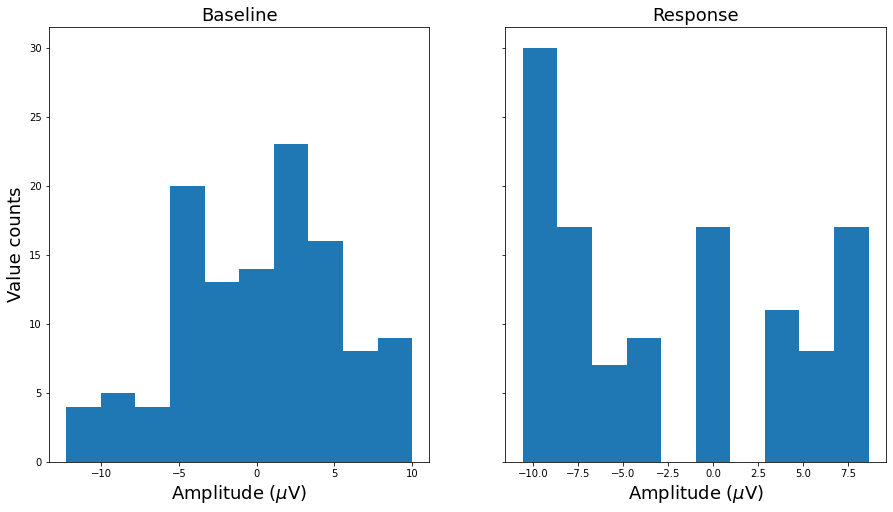

In [29]:
fig, ax = plt.subplots(1,2, figsize=(15,8), sharey=True)

font = {'size': 18}

ax[0].hist(sample_baseline, bins=10)
ax[0].set_title('Baseline',fontdict=font)
ax[0].set_xlabel(r'Amplitude ($\mu$V)',fontdict=font)
ax[0].set_ylabel(r'Value counts',fontdict=font)

ax[1].hist(sample_response, bins=10)
ax[1].set_title('Response',fontdict=font)
ax[1].set_xlabel(r'Amplitude ($\mu$V)',fontdict=font)

plt.savefig('./images/histograms.png')
plt.show()

### KDE

We can create also a Kernel Density Estimator to show a better non-parametric density estimation of the data by using several Sklearn functions.

We use a GridSearchCV to select the best bandwidth for each of the lists. We use Epanechnikov kernel since we have a bounded quantity.

In [35]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)

grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(sample_baseline[:, None])

best_bandwidth_baseline = grid.best_params_['bandwidth']

grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(sample_response[:, None])

best_bandwidth_response = grid.best_params_['bandwidth']

print('Best bandwidth baseline: ',best_bandwidth_baseline)
print('Best bandwidth response: ',best_bandwidth_response)

Best bandwidth baseline:  1.1233240329780276
Best bandwidth response:  0.1


In [31]:
model_baseline = KernelDensity(bandwidth=best_bandwidth_baseline, kernel='epanechnikov').fit(sample_baseline[:,None])
model_response = KernelDensity(bandwidth=best_bandwidth_response, kernel='epanechnikov').fit(sample_response[:,None])

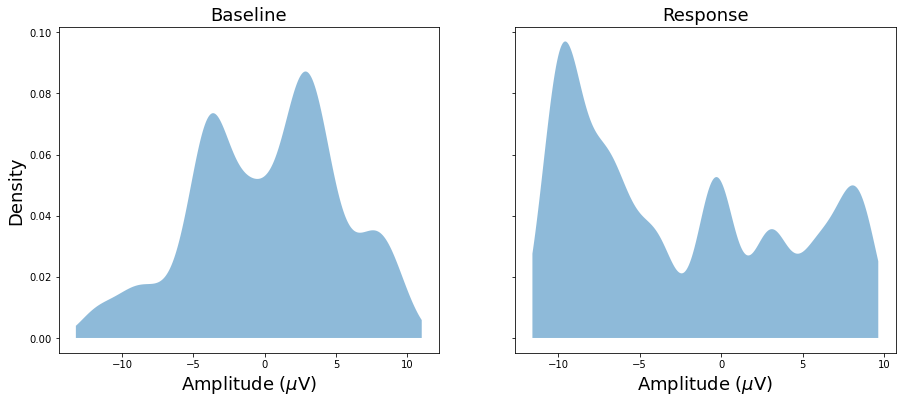

In [42]:
fig, ax = plt.subplots(1,2, figsize=(15,6),sharey=True)

font = {'size': 18}

values = np.linspace(min(sample_baseline) - 1, max(sample_baseline) + 1, num=500)
log_prob = model_baseline.score_samples(values[:,None])

ax[0].fill_between(values, np.exp(log_prob), alpha=0.5)
# ax[0].plot(sample_baseline, np.full_like(sample_baseline, -0.01), '|k', markeredgewidth=1)

ax[0].set_title('Baseline',fontdict=font)
ax[0].set_xlabel(r'Amplitude ($\mu$V)',fontdict=font)
ax[0].set_ylabel('Density',fontdict=font)

values = np.linspace(min(sample_response) - 1, max(sample_response) + 1, num=500)
log_prob = model_response.score_samples(values[:,None])

ax[1].fill_between(values, np.exp(log_prob), alpha=0.5)
# ax[1].plot(sample_response, np.full_like(sample_response, -0.01), '|k', markeredgewidth=1)

ax[1].set_title('Response',fontdict=font)
ax[1].set_xlabel(r'Amplitude ($\mu$V)',fontdict=font)

plt.savefig('./images/kde.png')
plt.show()

We see that the distributions are quite different, not only in the form but also in the width. Therefore we can assume that we are in a case of clear response.

# Bayesian Method

\begin{align*}
\phi(R\mid s_{1},s_{2},..,s_{n},stimulus) = 1- \frac{\prod_{i = 1}^{n} P(s_{i} \mid baseline)}{\prod_{i = 1}^{n} P(s_{i} \mid stimulus)} \geq \ p_r
\end{align*}

## References
<a id="1">[1]</a> 
Rodriguez, F. B. and Huerta R. (2009). 
Techniques for temporal detection of neural sensitivity to external stimulation. 
Biological Cybernetics, 4, 289-297.

<a id="1">[2]</a> 
Rodriguez, F. B. and Huerta R. and Alwyn M. L.(2013). 
Neural Sensitivity to Odorants in Deprived and Normal Olfactory Bulbs. 
PLOS One, 8, 1-11.

## Event counting method based on maximun values

In [11]:
def event_counter_max_method(run_eeg, run_check, center, semi_width, size):
    """
    Gets the probability of finding the maximum value of the trial inside the defined stimulus window for trials containing
    target images
    
    Args:
        run_eeg: Values of electroencefalogram of the run (n_electrodes x n_points x n_trials)
        run_check: Array n_images indicating if the image is the target the subject is thinking or not
        center: Position of the center of the stimulus window
        semi_width: Semi width of the stimulus window
        size: Number of trials desired to be taken acount in the calculations (generated via bootstrapping)
        
    Returns:
        response_prob: Array 1 x n_electodes containing the probability of finding the maximum value of the trial inside
                       the defined window i a target trial. One entry per electrode
        baseline_prob: Array 1 x n_electodes containing the probability of finding the maximum value of the trial inside
                       the defined window in a no target trial. One entry per electrode
    """
    
    mask = mask_generator(128, 700, center, semi_width)
    
    trial_counter = 0
    
    max_count_response = np.zeros(run_eeg.shape[0])
    max_count_baseline = np.zeros(run_eeg.shape[0])
    
    target_random, baseline_random = stimulus_baseline_window_obtainer(run_eeg, run_check, center, semi_width, size)
    
    for target_trial_number, baseline_trial_number in zip(target_random, baseline_random):
        
        target_trial = run_eeg[:,:len(mask), target_trial_number]
        baseline_trial = run_eeg[:,:len(mask), baseline_trial_number]
        
        window_check_response = np.array([mask[max_pos] for max_pos in np.argmax(target_trial, axis=1)])
        window_check_baseline = np.array([mask[max_pos] for max_pos in np.argmax(baseline_trial, axis=1)])
        
        max_count_response += window_check_response
        max_count_baseline += window_check_baseline
        
        trial_counter += 1
        
    response_prob = max_count_response / trial_counter
    baseline_prob = max_count_baseline / trial_counter

    return response_prob, baseline_prob

### Using the method for one session of one subject

In [20]:
response_sesion, baseline_sesion = 0, 0

for run in su_6_clean[0]:
    
    response_run, baseline_run = event_counter_max_method(run['eeg'], run['check'], 330, 30, 500)
    
    response_sesion += response_run
    baseline_sesion += baseline_run

response_sesion /= 6
baseline_sesion /= 6

resp_bound_session = 1 - baseline_sesion / response_sesion

resp_bound_session[resp_bound_session < 0] = 0
resp_bound_session[~np.isfinite(resp_bound_session)] = 0

resp_bound_session

array([0.08173077, 0.        , 0.        , 0.        , 0.12785388,
       0.        , 0.        , 0.        , 0.27969349, 0.07476636,
       0.        , 0.        , 0.50146628, 0.        , 0.        ,
       0.        , 0.        , 0.27572016, 0.33536585, 0.        ,
       0.12749004, 0.50137741, 0.5129683 , 0.14440433, 0.09452736,
       0.31229236, 0.49466192, 0.        , 0.        , 0.        ,
       0.22815534, 0.64353312])

### First approach colormap 

In [210]:
semi_widths = np.linspace(20, 200, 30)
centers = np.linspace(160, 600, 50)

data = [su_1_clean, su_2_clean, su_3_clean, su_4_clean, su_6_clean, su_7_clean, su_8_clean, su_9_clean]
probs = []

for user in data:

    lower_bound_prob_user = []

    for center in centers:
        for semi_width in semi_widths:
            
            response_sesion, baseline_sesion = 0, 0
            
            for run in user[0]:
                
                response_run, baseline_run = event_counter_max_method(run['eeg'], run['check'], center, semi_width, 300)
                
                response_sesion += response_run
                baseline_sesion += baseline_run

                response_sesion /= 6
                baseline_sesion /= 6

                resp_bound_session = 1 - baseline_sesion / response_sesion

                resp_bound_session[resp_bound_session < 0] = 0
                resp_bound_session[~np.isfinite(resp_bound_session)] = 0

            lower_bound_prob_user.append([center, semi_width, max(response_sesion),
                                          max(baseline_sesion), max(resp_bound_session)])


    probs.append(np.array(lower_bound_prob_user))


np.save('output_arrays/probs_all_subjects_max_method_session_one', probs)

C:\Users\lucia\AppData\Local\Temp/ipykernel_7884/3064885274.py:26: RuntimeWarning: divide by zero encountered in true_divide
  resp_bound_session = 1 - baseline_sesion / response_sesion
C:\Users\lucia\AppData\Local\Temp/ipykernel_7884/3064885274.py:26: RuntimeWarning: invalid value encountered in true_divide
  resp_bound_session = 1 - baseline_sesion / response_sesion


In [12]:
probs = np.load('output_arrays/probs_all_subjects_max_method_session_one.npy')

In [134]:
probs.shape

(8, 1500, 5)

#### Subject 1

In [13]:
center     = probs[0][:][:,0]
semiwidth  = probs[0][:][:,1]
prob_resp  = probs[0][:][:,2]
prob_base  = probs[0][:][:,3]
prob_bound = probs[0][:][:,4]

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z1, Z2, Z3 = np.reshape(prob_resp,(50,30)), np.reshape(prob_base,(50,30)), np.reshape(prob_bound,(50,30))

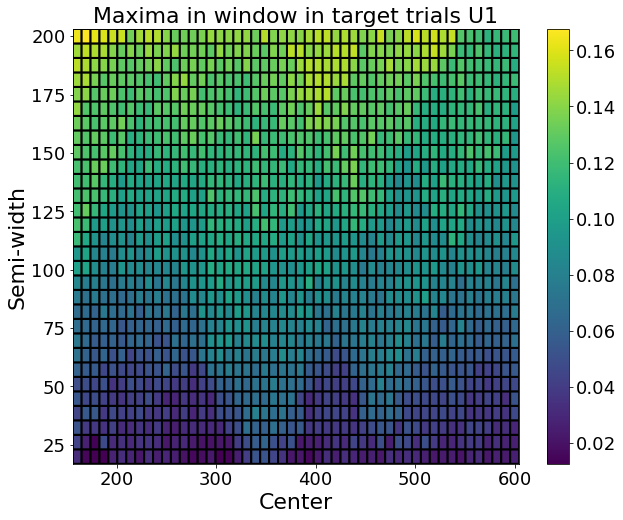

In [27]:
fig, ax = plt.subplots(figsize=(10,8))

cf0 = plt.pcolor(X, Y, Z1, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)

font = {'size': 22}
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

ax.set_title('Maxima in window in target trials U1', fontdict=font)
plt.savefig('./images/bounds/first_approach/max/u1_target.png')
plt.show()

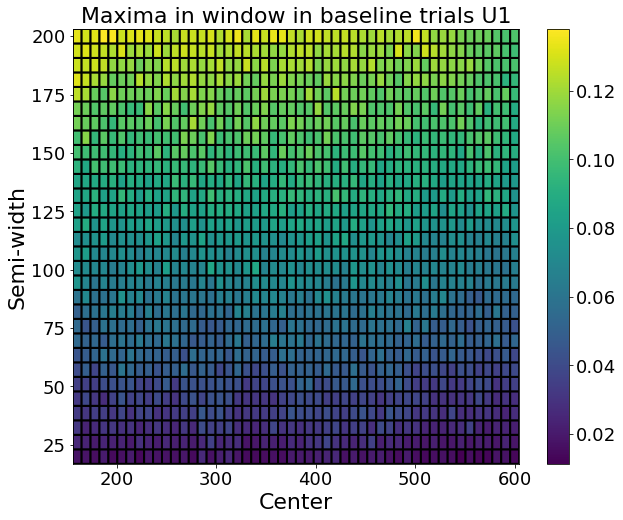

In [26]:
fig, ax = plt.subplots(figsize=(10,8))


cf0 = plt.pcolor(X, Y, Z2, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)

font = {'size': 22}
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

ax.set_title('Maxima in window in baseline trials U1', fontdict=font)
plt.savefig('./images/bounds/first_approach/max/u1_baseline.png')
plt.show()

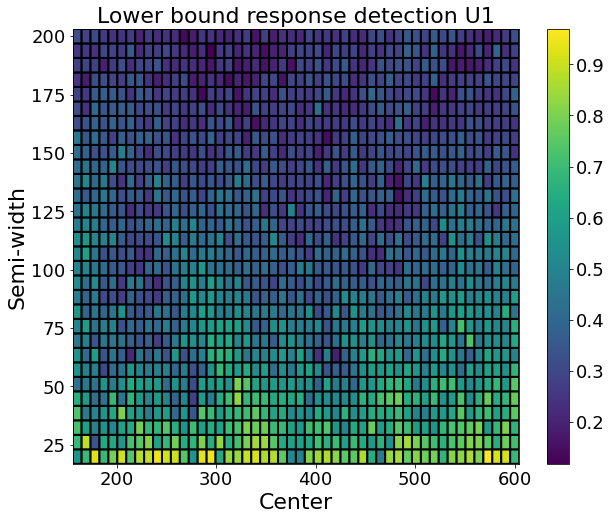

In [28]:
fig, ax = plt.subplots(figsize=(10,8))

cf0 = plt.pcolor(X, Y, Z3, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title('Lower bound response detection U1', fontdict=font)

font = {'size': 22}
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('./images/bounds/first_approach/max/u1_bound.png')
plt.show()

#### subject 2

In [32]:
center     = probs[1][:][:,0]
semiwidth  = probs[1][:][:,1]
prob_resp  = probs[1][:][:,2]
prob_base  = probs[1][:][:,3]
prob_bound = probs[1][:][:,4]

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z1, Z2, Z3 = np.reshape(prob_resp,(50,30)), np.reshape(prob_base,(50,30)), np.reshape(prob_bound,(50,30))

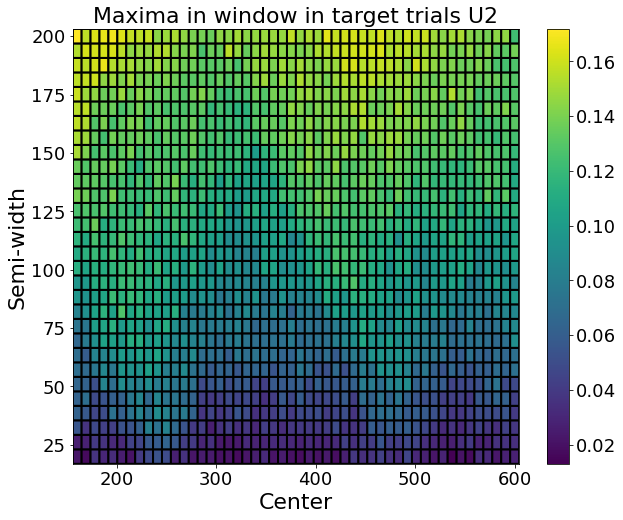

In [33]:
fig, ax = plt.subplots(figsize=(10,8))

cf0 = plt.pcolor(X, Y, Z1, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)

font = {'size': 22}
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

ax.set_title('Maxima in window in target trials U2', fontdict=font)
plt.savefig('./images/bounds/first_approach/max/u2_target.png')
plt.show()

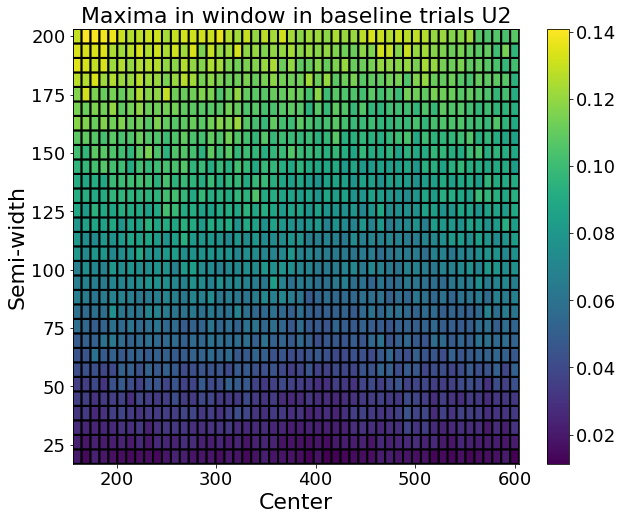

In [34]:
fig, ax = plt.subplots(figsize=(10,8))

cf0 = plt.pcolor(X, Y, Z2, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title('Maxima in window in baseline trials U2', fontdict=font)

font = {'size': 22}
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('./images/bounds/first_approach/max/u2_baseline.png')
plt.show()

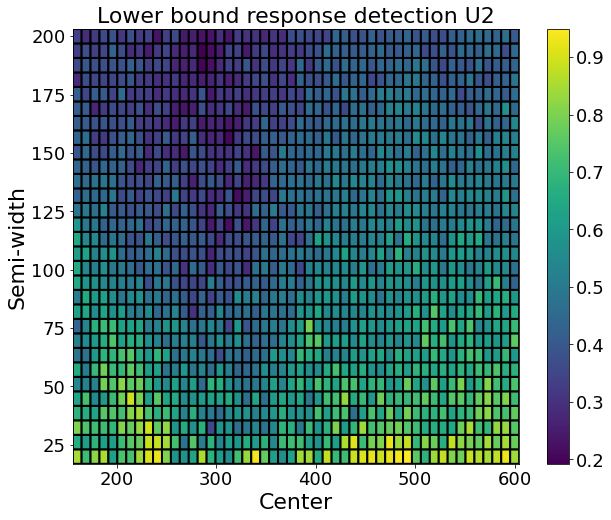

In [35]:
fig, ax = plt.subplots(figsize=(10,8))

cf0 = plt.pcolor(X, Y, Z3, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title('Lower bound response detection U2', fontdict=font)

font = {'size': 22}
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('./images/bounds/first_approach/max/u2_bound.png')
plt.show()

#### Subject 3

In [36]:
center     = probs[2][:][:,0]
semiwidth  = probs[2][:][:,1]
prob_resp  = probs[2][:][:,2]
prob_base  = probs[2][:][:,3]
prob_bound = probs[2][:][:,4]

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z1, Z2, Z3 = np.reshape(prob_resp,(50,30)), np.reshape(prob_base,(50,30)), np.reshape(prob_bound,(50,30))

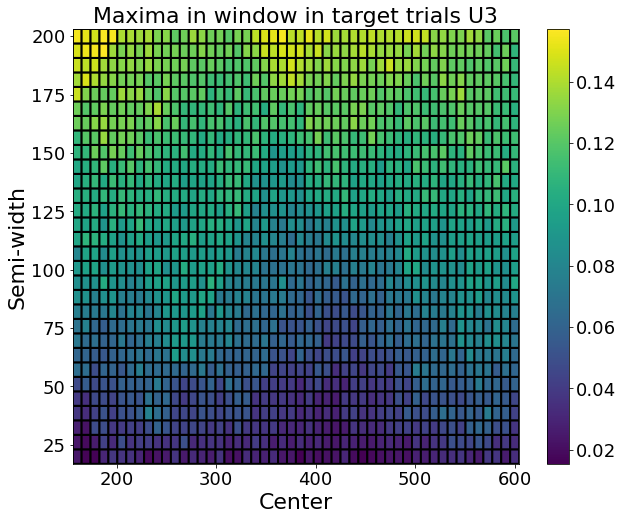

In [37]:
fig, ax = plt.subplots(figsize=(10,8))

cf0 = plt.pcolor(X, Y, Z1, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title('Maxima in window in target trials U3', fontdict=font)

font = {'size': 22}
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('./images/bounds/first_approach/max/u3_target.png')
plt.show()

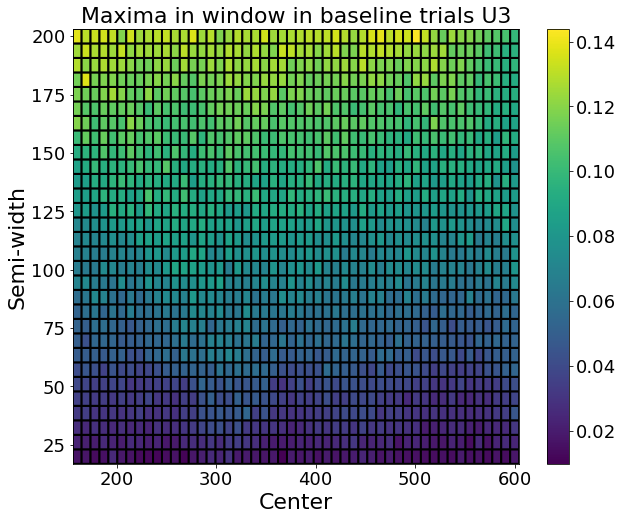

In [38]:
fig, ax = plt.subplots(figsize=(10,8))

cf0 = plt.pcolor(X, Y, Z2, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title('Maxima in window in baseline trials U3', fontdict=font)

font = {'size': 22}
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('./images/bounds/first_approach/max/u3_baseline.png')
plt.show()

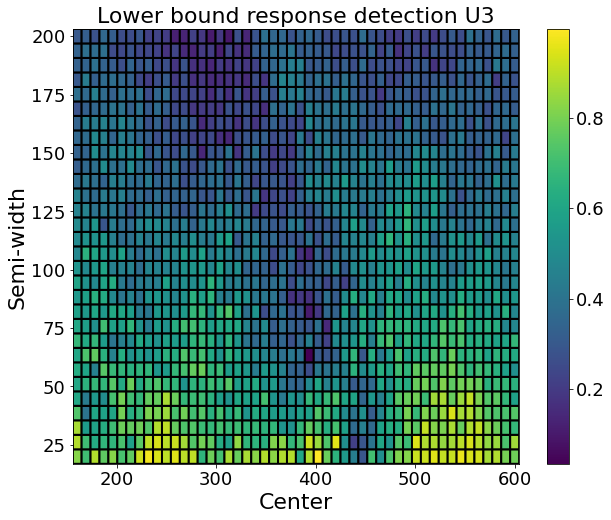

In [39]:
fig, ax = plt.subplots(figsize=(10,8))

cf0 = plt.pcolor(X, Y, Z3, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title('Lower bound response detection U3', fontdict=font)

font = {'size': 22}
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('./images/bounds/first_approach/max/u3_bound.png')
plt.show()

#### Subject 4

In [40]:
center     = probs[3][:][:,0]
semiwidth  = probs[3][:][:,1]
prob_resp  = probs[3][:][:,2]
prob_base  = probs[3][:][:,3]
prob_bound = probs[3][:][:,4]

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z1, Z2, Z3 = np.reshape(prob_resp,(50,30)), np.reshape(prob_base,(50,30)), np.reshape(prob_bound,(50,30))

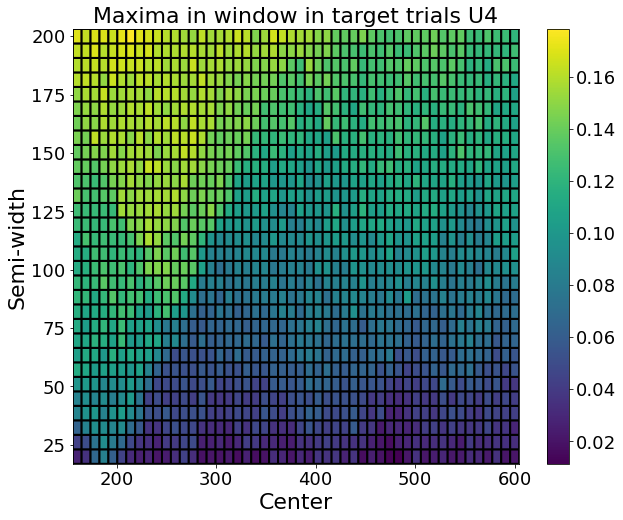

In [41]:
fig, ax = plt.subplots(figsize=(10,8))

cf0 = plt.pcolor(X, Y, Z1, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title('Maxima in window in target trials U4', fontdict=font)

font = {'size': 22}
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('./images/bounds/first_approach/max/u4_target.png')
plt.show()

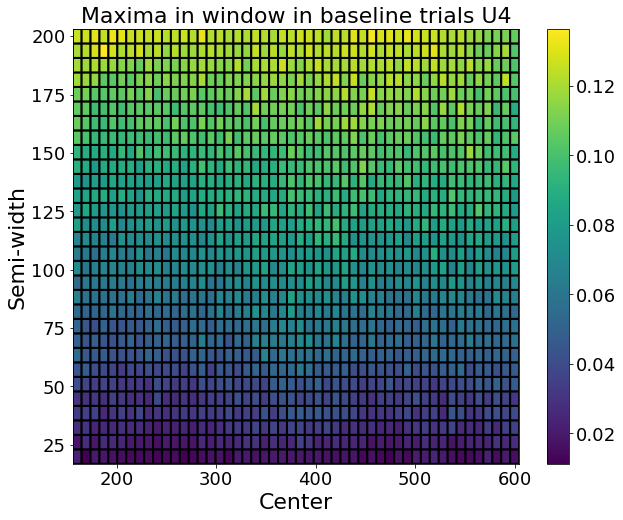

In [42]:
fig, ax = plt.subplots(figsize=(10,8))

cf0 = plt.pcolor(X, Y, Z2, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title('Maxima in window in baseline trials U4', fontdict=font)

font = {'size': 22}
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('./images/bounds/first_approach/max/u4_baseline.png')
plt.show()

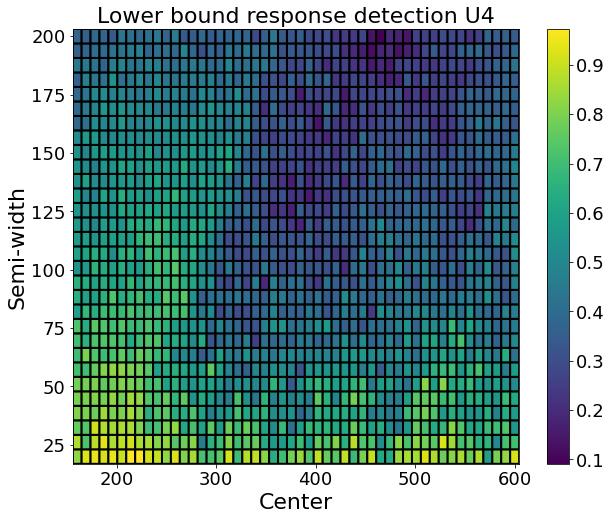

In [43]:
fig, ax = plt.subplots(figsize=(10,8))

cf0 = plt.pcolor(X, Y, Z3, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title('Lower bound response detection U4', fontdict=font)

font = {'size': 22}
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('./images/bounds/first_approach/max/u4_bound.png')
plt.show()

#### Subject 6

In [54]:
center     = probs[4][:][:,0]
semiwidth  = probs[4][:][:,1]
prob_resp  = probs[4][:][:,2]
prob_base  = probs[4][:][:,3]
prob_bound = probs[4][:][:,4]

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z1, Z2, Z3 = np.reshape(prob_resp,(50,30)), np.reshape(prob_base,(50,30)), np.reshape(prob_bound,(50,30))

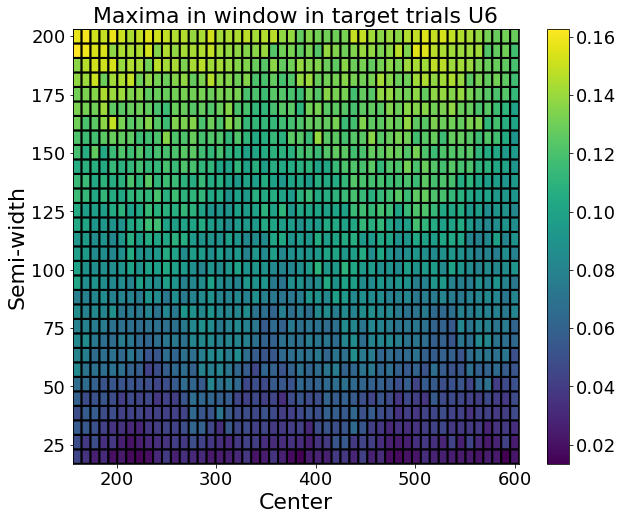

In [55]:
fig, ax = plt.subplots(figsize=(10,8))

cf0 = plt.pcolor(X, Y, Z1, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title('Maxima in window in target trials U6', fontdict=font)

font = {'size': 22}
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('./images/bounds/first_approach/max/u6_target.png')
plt.show()

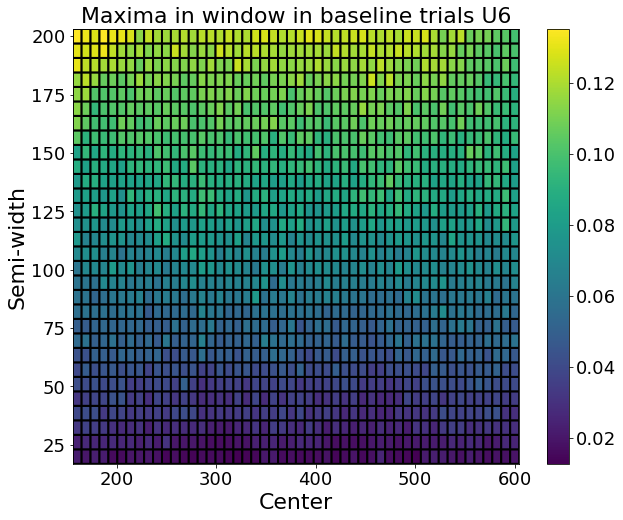

In [56]:
fig, ax = plt.subplots(figsize=(10,8))

cf0 = plt.pcolor(X, Y, Z2, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title('Maxima in window in baseline trials U6', fontdict=font)

font = {'size': 22}
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('./images/bounds/first_approach/max/u6_baseline.png')
plt.show()

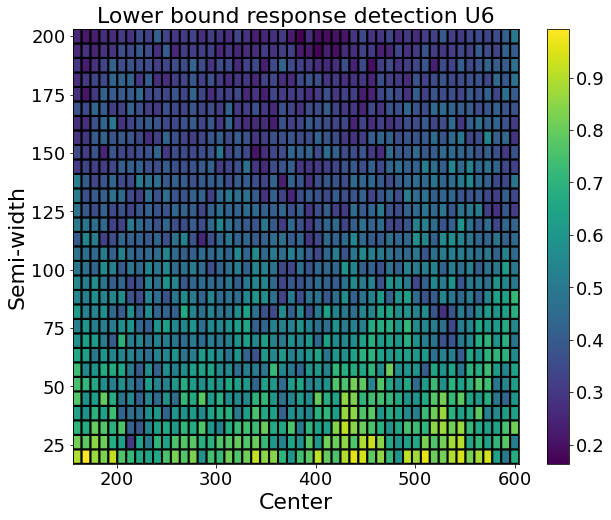

In [47]:
fig, ax = plt.subplots(figsize=(10,8))

cf0 = plt.pcolor(X, Y, Z3, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title('Lower bound response detection U6', fontdict=font)

font = {'size': 22}
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('./images/bounds/first_approach/max/u6_bound.png')
plt.show()

#### Subject 7

In [48]:
center     = probs[5][:][:,0]
semiwidth  = probs[5][:][:,1]
prob_resp  = probs[5][:][:,2]
prob_base  = probs[5][:][:,3]
prob_bound = probs[5][:][:,4]

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z1, Z2, Z3 = np.reshape(prob_resp,(50,30)), np.reshape(prob_base,(50,30)), np.reshape(prob_bound,(50,30))

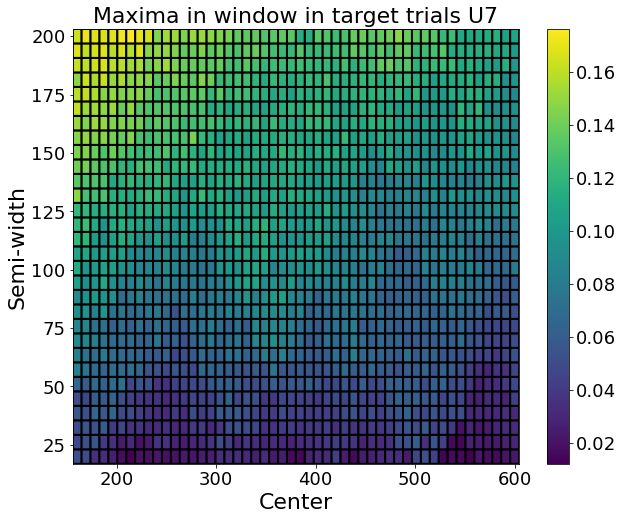

In [51]:
fig, ax = plt.subplots(figsize=(10,8))

cf0 = plt.pcolor(X, Y, Z1, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title('Maxima in window in target trials U7', fontdict=font)

font = {'size': 22}
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('./images/bounds/first_approach/max/u7_target.png')
plt.show()

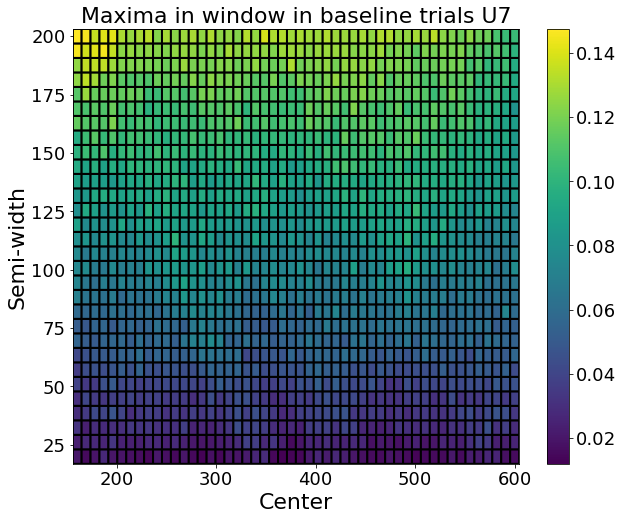

In [52]:
fig, ax = plt.subplots(figsize=(10,8))

cf0 = plt.pcolor(X, Y, Z2, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title('Maxima in window in baseline trials U7', fontdict=font)

font = {'size': 22}
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('./images/bounds/first_approach/max/u7_baseline.png')
plt.show()

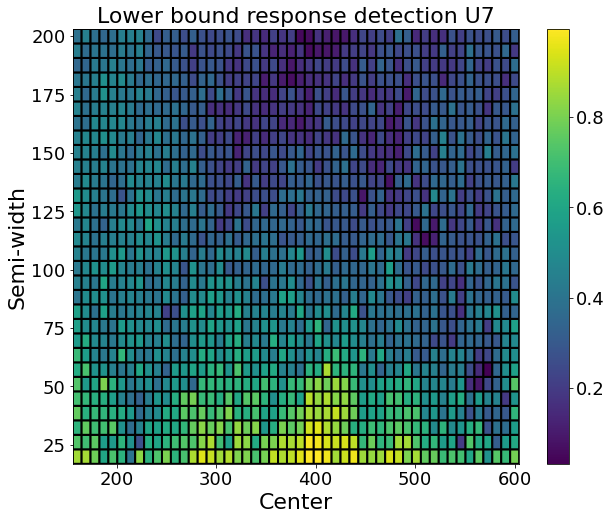

In [53]:
fig, ax = plt.subplots(figsize=(10,8))

cf0 = plt.pcolor(X, Y, Z3, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title('Lower bound response detection U7', fontdict=font)

font = {'size': 22}
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('./images/bounds/first_approach/max/u7_bound.png')
plt.show()

#### Subject 8

In [57]:
center     = probs[6][:][:,0]
semiwidth  = probs[6][:][:,1]
prob_resp  = probs[6][:][:,2]
prob_base  = probs[6][:][:,3]
prob_bound = probs[6][:][:,4]

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z1, Z2, Z3 = np.reshape(prob_resp,(50,30)), np.reshape(prob_base,(50,30)), np.reshape(prob_bound,(50,30))

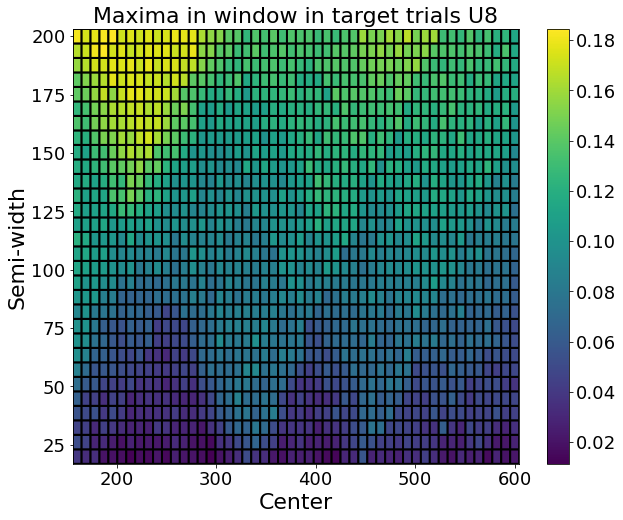

In [58]:
fig, ax = plt.subplots(figsize=(10,8))

cf0 = plt.pcolor(X, Y, Z1, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title('Maxima in window in target trials U8', fontdict=font)

font = {'size': 22}
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('./images/bounds/first_approach/max/u8_target.png')
plt.show()

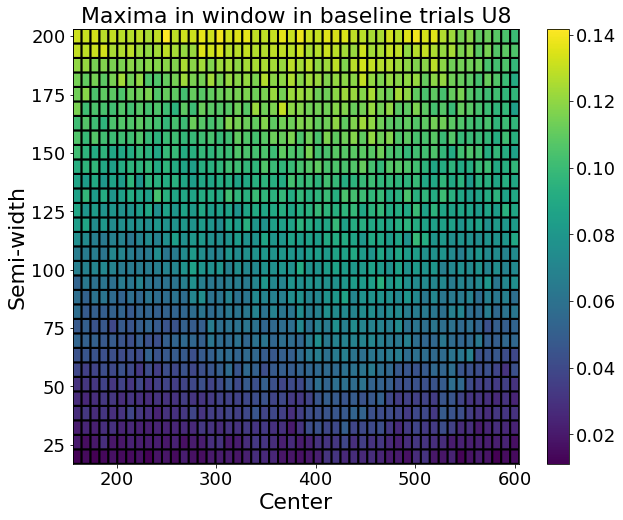

In [59]:
fig, ax = plt.subplots(figsize=(10,8))

cf0 = plt.pcolor(X, Y, Z2, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title('Maxima in window in baseline trials U8', fontdict=font)

font = {'size': 22}
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('./images/bounds/first_approach/max/u8_baseline.png')
plt.show()

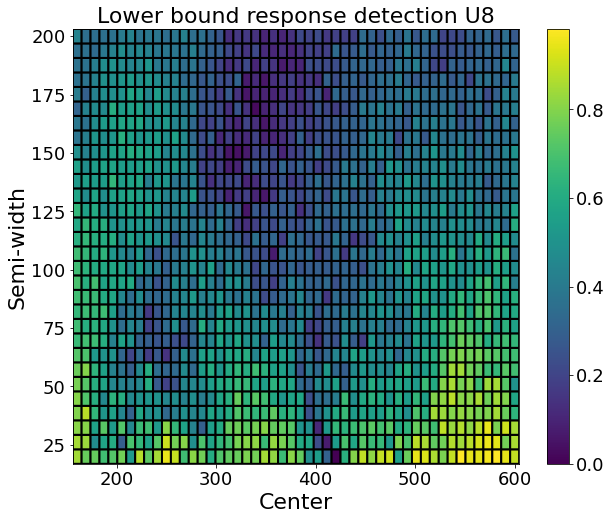

In [60]:
fig, ax = plt.subplots(figsize=(10,8))


cf0 = plt.pcolor(X, Y, Z3, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title('Lower bound response detection U8', fontdict=font)

font = {'size': 22}
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('./images/bounds/first_approach/max/u8_bound.png')
plt.show()

#### Subject 9

In [61]:
center     = probs[7][:][:,0]
semiwidth  = probs[7][:][:,1]
prob_resp  = probs[7][:][:,2]
prob_base  = probs[7][:][:,3]
prob_bound = probs[7][:][:,4]

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z1, Z2, Z3 = np.reshape(prob_resp,(50,30)), np.reshape(prob_base,(50,30)), np.reshape(prob_bound,(50,30))

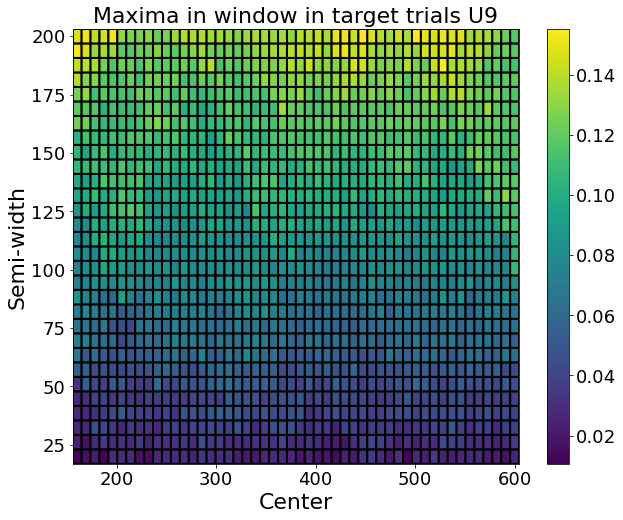

In [62]:
fig, ax = plt.subplots(figsize=(10,8))

cf0 = plt.pcolor(X, Y, Z1, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title('Maxima in window in target trials U9', fontdict=font)

font = {'size': 22}
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('./images/bounds/first_approach/max/u9_target.png')
plt.show()

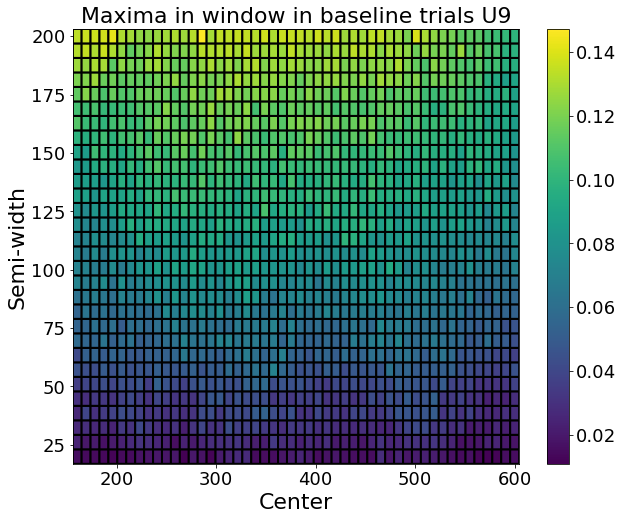

In [63]:
fig, ax = plt.subplots(figsize=(10,8))

cf0 = plt.pcolor(X, Y, Z2, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title('Maxima in window in baseline trials U9', fontdict=font)

font = {'size': 22}
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('./images/bounds/first_approach/max/u9_baseline.png')
plt.show()

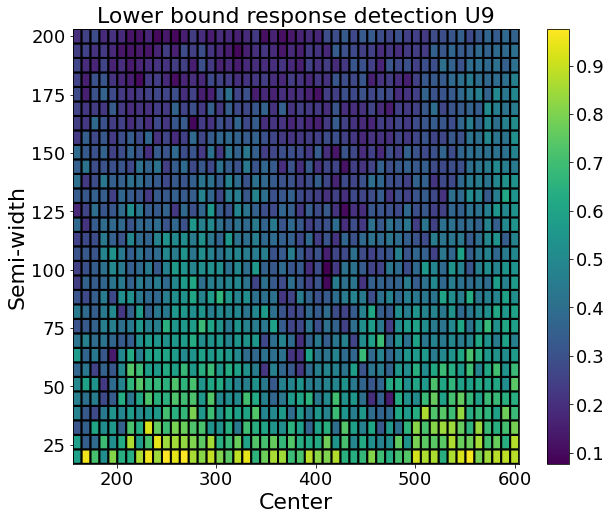

In [64]:
fig, ax = plt.subplots(figsize=(10,8))

cf0 = plt.pcolor(X, Y, Z3, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title('Lower bound response detection U9', fontdict=font)

font = {'size': 22}
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('./images/bounds/first_approach/max/u9_bound.png')
plt.show()

### Selecting optimal values for all users

#### Best electrode of day 1

In [100]:
semi_widths = np.linspace(20, 200, 30)
centers = np.linspace(160, 600, 50)

data = [su_1_clean, su_2_clean, su_3_clean, su_4_clean, su_6_clean, su_7_clean, su_8_clean, su_9_clean]
probs = []

for user in data:

    lower_bound_prob_user = []

    for center in centers:
        for semi_width in semi_widths:
            
            resp_bound_sesion_1, resp_bound_sesion_2 = 0, 0
                        
            for run in user[0]:
                
                response_run, baseline_run = event_counter_max_method(run['eeg'], run['check'], center, semi_width, 500)
                
                resp_bound_run = 1 - baseline_run / response_run
                
                resp_bound_sesion_1 += resp_bound_run
                
            resp_bound_sesion_1[resp_bound_sesion_1 < 0] = 0
            resp_bound_sesion_1[~np.isfinite(resp_bound_sesion_1)] = 0                
            
            resp_bound_sesion_1 /= 6
            
            for run in user[1]:
                
                response_run, baseline_run = event_counter_max_method(run['eeg'], run['check'], center, semi_width, 500)
                
                resp_bound_run = 1 - baseline_run / response_run
                
                resp_bound_sesion_2 += resp_bound_run
                
            resp_bound_sesion_2[resp_bound_sesion_2 < 0] = 0
            resp_bound_sesion_2[~np.isfinite(resp_bound_sesion_2)] = 0 

            resp_bound_sesion_2 /= 6
            
            resp_bound_day = (resp_bound_sesion_1 + resp_bound_sesion_2) / 2

            lower_bound_prob_user.append([center, semi_width, resp_bound_day])


    probs.append(np.array(lower_bound_prob_user))

np.save('output_arrays/probs_all_subjects_all_electrodes_day_one', probs)

C:\Users\lucia\AppData\Local\Temp\ipykernel_4208\544323963.py:20: RuntimeWarning: divide by zero encountered in true_divide
  resp_bound_run = 1 - baseline_run / response_run
C:\Users\lucia\AppData\Local\Temp\ipykernel_4208\544323963.py:20: RuntimeWarning: invalid value encountered in true_divide
  resp_bound_run = 1 - baseline_run / response_run
C:\Users\lucia\AppData\Local\Temp\ipykernel_4208\544323963.py:33: RuntimeWarning: divide by zero encountered in true_divide
  resp_bound_run = 1 - baseline_run / response_run
C:\Users\lucia\AppData\Local\Temp\ipykernel_4208\544323963.py:33: RuntimeWarning: invalid value encountered in true_divide
  resp_bound_run = 1 - baseline_run / response_run
C:\Users\lucia\AppData\Local\Temp\ipykernel_4208\544323963.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=objec

In [59]:
probs_day_1 = np.load('output_arrays/probs_all_subjects_all_electrodes_day_one.npy',allow_pickle=True)

In [60]:
best_electrodes_d1 = []

for user in probs_day_1:
    
    best_combinations = []

    for combination in sorted(user, key = lambda x: max(x[2]), reverse=True):

        best_combinations.append(np.argmax(combination[2]))

    best_electrodes_d1.append(best_combinations[:500])

#### Best electrode of day 2

In [8]:
semi_widths = np.linspace(20, 200, 30)
centers = np.linspace(160, 600, 50)

data = [su_1_clean, su_2_clean, su_3_clean, su_4_clean, su_6_clean, su_7_clean, su_8_clean, su_9_clean]
probs = []

for user in data:

    lower_bound_prob_user = []

    for center in centers:
        for semi_width in semi_widths:
            
            resp_bound_sesion_3, resp_bound_sesion_4 = 0, 0
                        
            for run in user[2]:
                
                response_run, baseline_run = event_counter_max_method(run['eeg'], run['check'], center, semi_width, 500)
                
                resp_bound_run = 1 - baseline_run / response_run
                
                resp_bound_sesion_3 += resp_bound_run
                
            resp_bound_sesion_3[resp_bound_sesion_3 < 0] = 0
            resp_bound_sesion_3[~np.isfinite(resp_bound_sesion_3)] = 0    
            
            resp_bound_sesion_3 /= 6
            
            for run in user[3]:
                
                response_run, baseline_run = event_counter_max_method(run['eeg'], run['check'], center, semi_width, 500)
                
                resp_bound_run = 1 - baseline_run / response_run
                
                resp_bound_sesion_4 += resp_bound_run
                
            resp_bound_sesion_4[resp_bound_sesion_4 < 0] = 0
            resp_bound_sesion_4[~np.isfinite(resp_bound_sesion_4)] = 0    

            resp_bound_sesion_4 /= 6
            
            resp_bound_day = (resp_bound_sesion_3 + resp_bound_sesion_4) / 2

            lower_bound_prob_user.append([center, semi_width, resp_bound_day])


    probs.append(np.array(lower_bound_prob_user))

np.save('output_arrays/probs_all_subjects_all_electrodes_day_two', probs)

NameError: name 'su_1_clean' is not defined

In [61]:
probs_day_2 = np.load('output_arrays/probs_all_subjects_all_electrodes_day_two.npy',allow_pickle=True)

In [62]:
best_electrodes_d2 = []

for user in probs_day_2:
    
    best_combinations = []

    for combination in sorted(user, key = lambda x: max(x[2]), reverse=True):

        best_combinations.append((np.argmax(combination[2])))

    best_electrodes_d2.append(best_combinations[:200])

#### Best electrode summary

In [21]:
best_d1

[[1, 29, 0, 16, 2, 3, 10, 5],
 [2, 16, 19, 6, 29, 0, 1, 27],
 [0, 30, 3, 11, 21, 13, 1, 8],
 [5, 11, 25, 31, 1, 3, 22, 28],
 [26, 29, 25, 7, 24, 16, 8, 4],
 [17, 13, 30, 26, 29, 4, 14, 12],
 [4, 8, 25, 0, 28, 3, 10, 30],
 [7, 8, 13, 0, 12, 18, 10, 27]]

In [22]:
best_d2

[[1, 0, 28, 20, 5, 10, 2, 29],
 [13, 9, 11, 12, 15, 29, 8, 7],
 [11, 8, 29, 30, 23, 25, 27, 17],
 [25, 1, 11, 30, 7, 3, 9, 29],
 [31, 25, 22, 14, 19, 5, 6, 16],
 [26, 19, 25, 7, 10, 4, 3, 8],
 [25, 29, 0, 7, 30, 11, 10, 13],
 [23, 22, 6, 29, 11, 2, 10, 24]]

In [63]:
standard_electrode = [12, 31, 30, 15, 10, 11, 18, 19]

In [64]:
from collections import OrderedDict 

best_d1, best_d2 = [], []
best_d1_name, best_d2_name = [], []

users = [1,2,3,4,6,7,8,9]

for user_1, user_3 in zip(best_electrodes_d1, best_electrodes_d2):
    
    result_1 = list(OrderedDict.fromkeys(user_1))[:8]
    result_3 = list(OrderedDict.fromkeys(user_3))[:8]
    
    best_d1.append([int(electrode) for electrode in result_1])
    best_d2.append([int(electrode) for electrode in result_3])
    
best_d1_name = [[electrode_list[electrode] for electrode in user] for user in best_d1]
best_d2_name = [[electrode_list[electrode] for electrode in user] for user in best_d2]

print('\n------------------- DAY 1 -------------------\n')
for user, best_electrode_list in zip(users, best_d1_name):
    print(f'The 8 bests electrodes for user {user} are {best_electrode_list}')

print('\n------------------- DAY 2 -------------------\n')
for user, best_electrode_list in zip(users, best_d2_name):
    print(f'The 8 bests electrodes for user {user} are {best_electrode_list}')


------------------- DAY 1 -------------------

The 8 bests electrodes for user 1 are ['AF3', 'Fp2', 'Fp1', 'O2', 'F7', 'F3', 'P7', 'FC5']
The 8 bests electrodes for user 2 are ['F7', 'O2', 'P8', 'T7', 'Fp2', 'Fp1', 'AF3', 'F8']
The 8 bests electrodes for user 3 are ['Fp1', 'Fz', 'F3', 'P3', 'CP2', 'PO3', 'AF3', 'CP1']
The 8 bests electrodes for user 4 are ['FC5', 'P3', 'FC2', 'Cz', 'AF3', 'F3', 'C4', 'AF4']
The 8 bests electrodes for user 6 are ['F4', 'Fp2', 'FC2', 'C3', 'FC6', 'O2', 'CP1', 'FC1']
The 8 bests electrodes for user 7 are ['PO4', 'PO3', 'Fz', 'F4', 'Fp2', 'FC1', 'O1', 'Pz']
The 8 bests electrodes for user 8 are ['FC1', 'CP1', 'FC2', 'Fp1', 'AF4', 'F3', 'P7', 'Fz']
The 8 bests electrodes for user 9 are ['C3', 'CP1', 'PO3', 'Fp1', 'Pz', 'P4', 'P7', 'F8']

------------------- DAY 2 -------------------

The 8 bests electrodes for user 1 are ['AF3', 'Fp1', 'AF4', 'CP6', 'FC5', 'P7', 'F7', 'Fp2']
The 8 bests electrodes for user 2 are ['PO3', 'CP5', 'P3', 'Pz', 'Oz', 'Fp2', 'CP1

#### Colormaps for each user with the best electrode

In [109]:
semi_widths = np.linspace(20, 200, 30)
centers = np.linspace(160, 600, 50)

data = [su_1_clean, su_2_clean, su_3_clean, su_4_clean, su_6_clean, su_7_clean, su_8_clean, su_9_clean]
best_electrodes = [best[0] for best in best_d1]

probs = []

for user, electrode in zip(data, best_electrodes):

    lower_bound_prob_user = []

    for center in centers:
        for semi_width in semi_widths:
            
            resp_bound_session = 0
            
            for run in user[0]:
                
                response_run, baseline_run = event_counter_max_method(run['eeg'], run['check'], center, semi_width, 300)
                
                resp_bound_run = 1 - baseline_run / response_run
                
                resp_bound_session += resp_bound_run
                
            resp_bound_session /= 6
                
            resp_bound_session[resp_bound_session < 0] = 0
            resp_bound_session[~np.isfinite(resp_bound_session)] = 0

            lower_bound_prob_user.append([center, semi_width, resp_bound_session[electrode]])


    probs.append(np.array(lower_bound_prob_user))

np.save('output_arrays/probs_all_subjects_best_electrode_session_one', probs)

C:\Users\lucia\AppData\Local\Temp\ipykernel_4208\55247863.py:22: RuntimeWarning: divide by zero encountered in true_divide
  resp_bound_run = 1 - baseline_run / response_run
C:\Users\lucia\AppData\Local\Temp\ipykernel_4208\55247863.py:22: RuntimeWarning: invalid value encountered in true_divide
  resp_bound_run = 1 - baseline_run / response_run


In [110]:
semi_widths = np.linspace(20, 200, 30)
centers = np.linspace(160, 600, 50)

data = [su_1_clean, su_2_clean, su_3_clean, su_4_clean, su_6_clean, su_7_clean, su_8_clean, su_9_clean]
best_electrodes = [best[0] for best in best_d1]

probs = []

for user, electrode in zip(data, best_electrodes):

    lower_bound_prob_user = []

    for center in centers:
        for semi_width in semi_widths:
            
            resp_bound_session = 0
            
            for run in user[1]:
                
                response_run, baseline_run = event_counter_max_method(run['eeg'], run['check'], center, semi_width, 300)
                
                resp_bound_run = 1 - baseline_run / response_run
                
                resp_bound_session += resp_bound_run
                
            resp_bound_session /= 6
                
            resp_bound_session[resp_bound_session < 0] = 0
            resp_bound_session[~np.isfinite(resp_bound_session)] = 0

            lower_bound_prob_user.append([center, semi_width, resp_bound_session[electrode]])


    probs.append(np.array(lower_bound_prob_user))

np.save('output_arrays/probs_all_subjects_best_electrode_session_two', probs)

C:\Users\lucia\AppData\Local\Temp\ipykernel_4208\1349878080.py:22: RuntimeWarning: divide by zero encountered in true_divide
  resp_bound_run = 1 - baseline_run / response_run
C:\Users\lucia\AppData\Local\Temp\ipykernel_4208\1349878080.py:22: RuntimeWarning: invalid value encountered in true_divide
  resp_bound_run = 1 - baseline_run / response_run


In [111]:
semi_widths = np.linspace(20, 200, 30)
centers = np.linspace(160, 600, 50)

data = [su_1_clean, su_2_clean, su_3_clean, su_4_clean, su_6_clean, su_7_clean, su_8_clean, su_9_clean]
best_electrodes = [best[0] for best in best_d2]

probs = []

for user, electrode in zip(data, best_electrodes):

    lower_bound_prob_user = []

    for center in centers:
        for semi_width in semi_widths:
            
            resp_bound_session = 0
            
            for run in user[2]:
                
                response_run, baseline_run = event_counter_max_method(run['eeg'], run['check'], center, semi_width, 300)
                
                resp_bound_run = 1 - baseline_run / response_run
                
                resp_bound_session += resp_bound_run
                
            resp_bound_session /= 6
                
            resp_bound_session[resp_bound_session < 0] = 0
            resp_bound_session[~np.isfinite(resp_bound_session)] = 0

            lower_bound_prob_user.append([center, semi_width, resp_bound_session[electrode]])


    probs.append(np.array(lower_bound_prob_user))


np.save('output_arrays/probs_all_subjects_best_electrode_session_three', probs)

C:\Users\lucia\AppData\Local\Temp\ipykernel_4208\1436396667.py:22: RuntimeWarning: divide by zero encountered in true_divide
  resp_bound_run = 1 - baseline_run / response_run
C:\Users\lucia\AppData\Local\Temp\ipykernel_4208\1436396667.py:22: RuntimeWarning: invalid value encountered in true_divide
  resp_bound_run = 1 - baseline_run / response_run


In [112]:
semi_widths = np.linspace(20, 200, 30)
centers = np.linspace(160, 600, 50)

data = [su_1_clean, su_2_clean, su_3_clean, su_4_clean, su_6_clean, su_7_clean, su_8_clean, su_9_clean]
best_electrodes = [best[0] for best in best_d2]

probs = []

for user, electrode in zip(data, best_electrodes):

    lower_bound_prob_user = []

    for center in centers:
        for semi_width in semi_widths:
            
            resp_bound_session = 0
            
            for run in user[3]:
                
                response_run, baseline_run = event_counter_max_method(run['eeg'], run['check'], center, semi_width, 300)
                
                resp_bound_run = 1 - baseline_run / response_run
                
                resp_bound_session += resp_bound_run
                
            resp_bound_session /= 6
                
            resp_bound_session[resp_bound_session < 0] = 0
            resp_bound_session[~np.isfinite(resp_bound_session)] = 0

            lower_bound_prob_user.append([center, semi_width, resp_bound_session[electrode]])


    probs.append(np.array(lower_bound_prob_user))


np.save('output_arrays/probs_all_subjects_best_electrode_session_four', probs)

C:\Users\lucia\AppData\Local\Temp\ipykernel_4208\170272827.py:22: RuntimeWarning: divide by zero encountered in true_divide
  resp_bound_run = 1 - baseline_run / response_run
C:\Users\lucia\AppData\Local\Temp\ipykernel_4208\170272827.py:22: RuntimeWarning: invalid value encountered in true_divide
  resp_bound_run = 1 - baseline_run / response_run


In [65]:
probs_best_electrode_s1 = np.load('output_arrays/probs_all_subjects_best_electrode_session_one.npy', allow_pickle=True)
probs_best_electrode_s2 = np.load('output_arrays/probs_all_subjects_best_electrode_session_two.npy', allow_pickle=True)
probs_best_electrode_s3 = np.load('output_arrays/probs_all_subjects_best_electrode_session_three.npy', allow_pickle=True)
probs_best_electrode_s4 = np.load('output_arrays/probs_all_subjects_best_electrode_session_four.npy', allow_pickle=True)

##### User 1

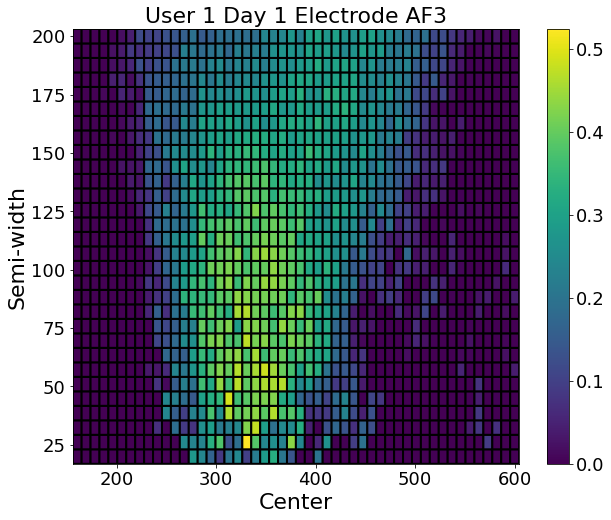

In [66]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s1[0][:][:,0] + probs_best_electrode_s2[0][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s1[0][:][:,1] + probs_best_electrode_s2[0][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s1[0][:][:,2] + probs_best_electrode_s2[0][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 1 Day 1 Electrode {best_d1_name[0][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u1/prob_bound_u1_d1_best_electrode.png')
plt.show()

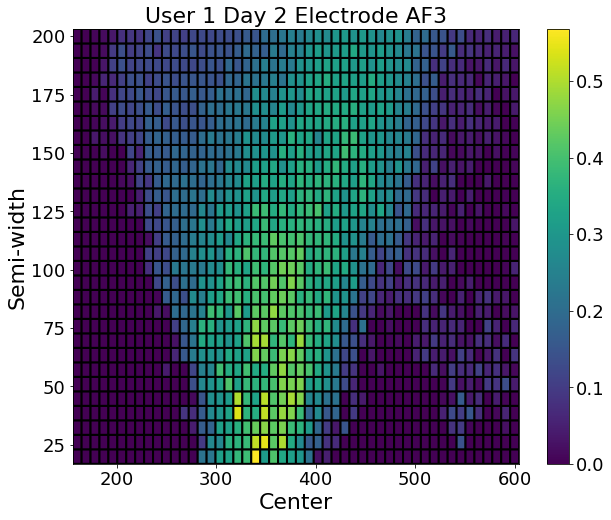

In [67]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s3[0][:][:,0] + probs_best_electrode_s4[0][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s3[0][:][:,1] + probs_best_electrode_s4[0][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s3[0][:][:,2] + probs_best_electrode_s4[0][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 1 Day 2 Electrode {best_d2_name[0][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u1/prob_bound_u1_d2_best_electrode.png')
plt.show()

##### User 2

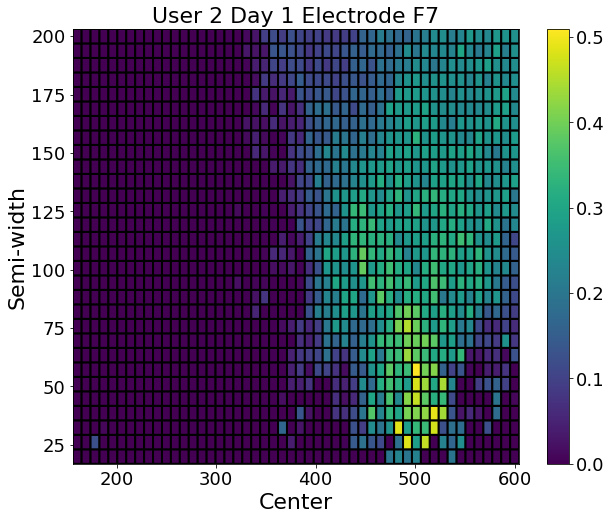

In [68]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s1[1][:][:,0] + probs_best_electrode_s2[1][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s1[1][:][:,1] + probs_best_electrode_s2[1][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s1[1][:][:,2] + probs_best_electrode_s2[1][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 2 Day 1 Electrode {best_d1_name[1][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u2/prob_bound_u2_d1_best_electrode.png')
plt.show()

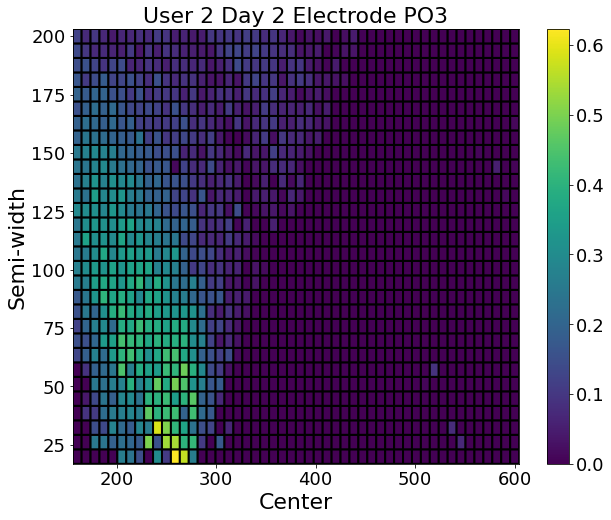

In [69]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s3[1][:][:,0] + probs_best_electrode_s4[1][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s3[1][:][:,1] + probs_best_electrode_s4[1][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s3[1][:][:,2] + probs_best_electrode_s4[1][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 2 Day 2 Electrode {best_d2_name[1][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u2/prob_bound_u2_d2_best_electrode.png')
plt.show()

##### User 3

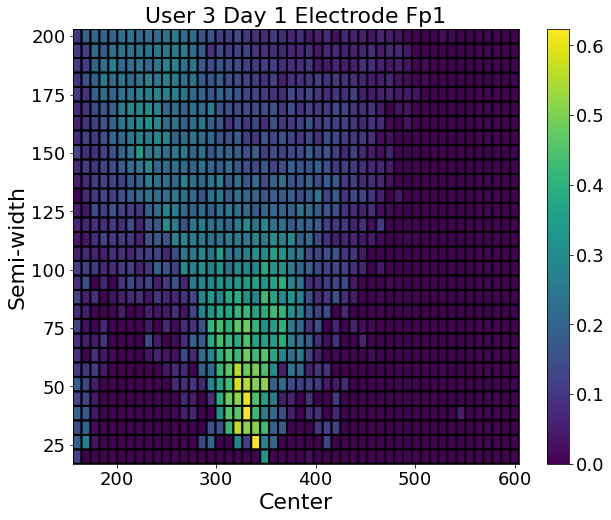

In [70]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s1[2][:][:,0] + probs_best_electrode_s2[2][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s1[2][:][:,1] + probs_best_electrode_s2[2][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s1[2][:][:,2] + probs_best_electrode_s2[2][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 3 Day 1 Electrode {best_d1_name[2][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u3/prob_bound_u3_d1_best_electrode.png')
plt.show()

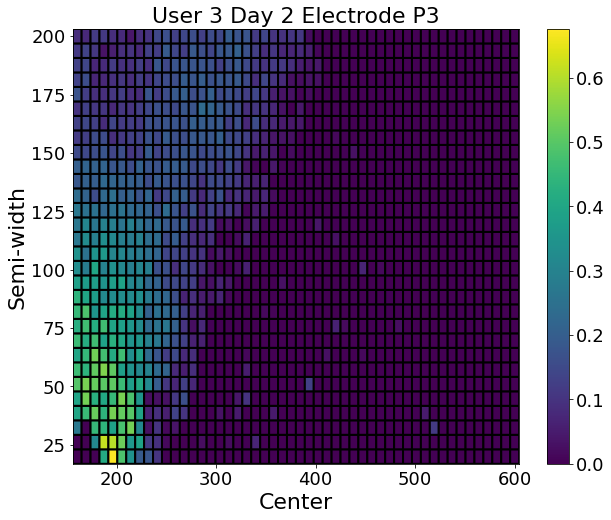

In [71]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s3[2][:][:,0] + probs_best_electrode_s4[2][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s3[2][:][:,1] + probs_best_electrode_s4[2][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s3[2][:][:,2] + probs_best_electrode_s4[2][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 3 Day 2 Electrode {best_d2_name[2][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u3/prob_bound_u3_d2_best_electrode.png')
plt.show()

##### User 4

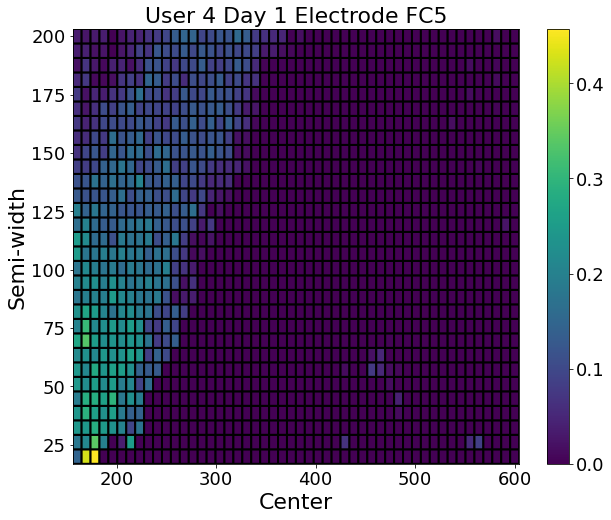

In [72]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s1[3][:][:,0] + probs_best_electrode_s2[3][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s1[3][:][:,1] + probs_best_electrode_s2[3][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s1[3][:][:,2] + probs_best_electrode_s2[3][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 4 Day 1 Electrode {best_d1_name[3][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u4/prob_bound_u4_d1_best_electrode.png')
plt.show()

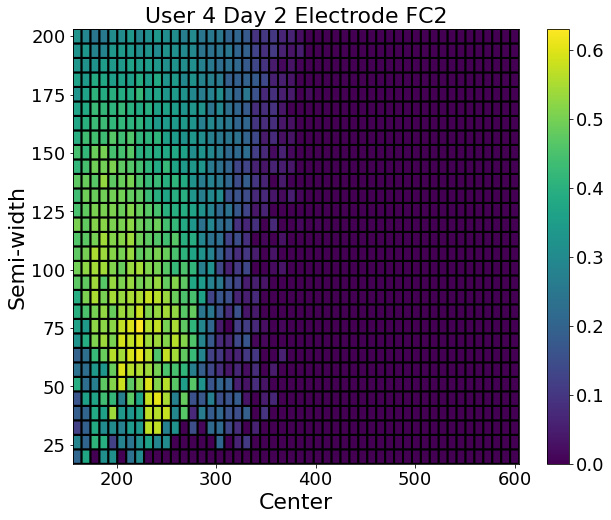

In [73]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s3[3][:][:,0] + probs_best_electrode_s4[3][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s3[3][:][:,1] + probs_best_electrode_s4[3][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s3[3][:][:,2] + probs_best_electrode_s4[3][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 4 Day 2 Electrode {best_d2_name[3][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u4/prob_bound_u4_d2_best_electrode.png')
plt.show()

##### User 6

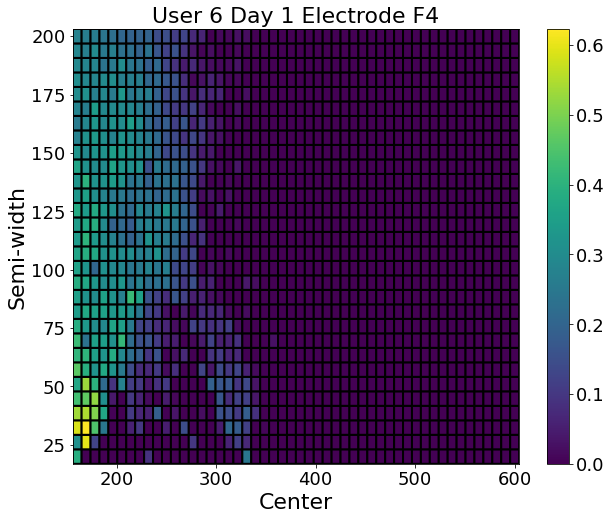

In [74]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s1[4][:][:,0] + probs_best_electrode_s2[4][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s1[4][:][:,1] + probs_best_electrode_s2[4][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s1[4][:][:,2] + probs_best_electrode_s2[4][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 6 Day 1 Electrode {best_d1_name[4][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u6/prob_bound_u6_d1_best_electrode.png')
plt.show()

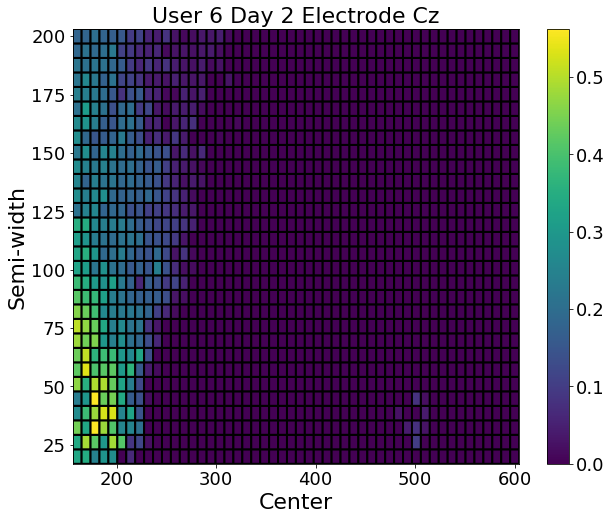

In [75]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s3[4][:][:,0] + probs_best_electrode_s4[4][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s3[4][:][:,1] + probs_best_electrode_s4[4][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s3[4][:][:,2] + probs_best_electrode_s4[4][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 6 Day 2 Electrode {best_d2_name[4][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u6/prob_bound_u6_d2_best_electrode.png')
plt.show()

##### User 7

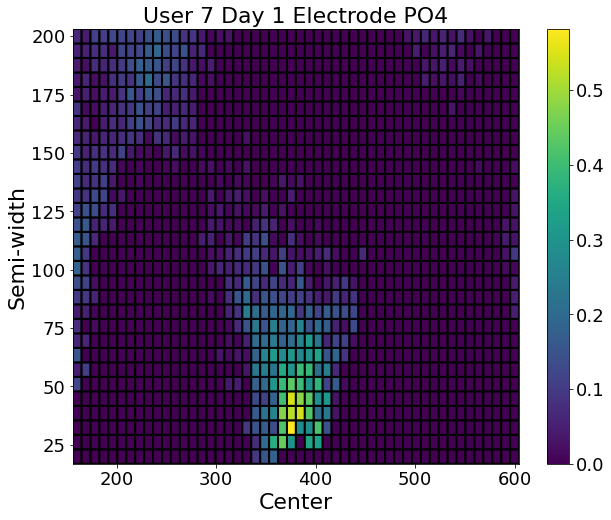

In [76]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s1[5][:][:,0] + probs_best_electrode_s2[5][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s1[5][:][:,1] + probs_best_electrode_s2[5][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s1[5][:][:,2] + probs_best_electrode_s2[5][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 7 Day 1 Electrode {best_d1_name[5][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u7/prob_bound_u7_d1_best_electrode.png')
plt.show()

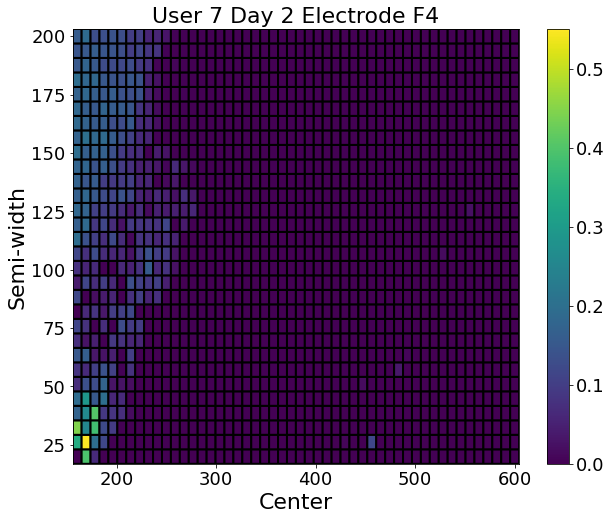

In [77]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s3[5][:][:,0] + probs_best_electrode_s4[5][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s3[5][:][:,1] + probs_best_electrode_s4[5][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s3[5][:][:,2] + probs_best_electrode_s4[5][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 7 Day 2 Electrode {best_d2_name[5][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u7/prob_bound_u7_d2_best_electrode.png')
plt.show()

##### User 8

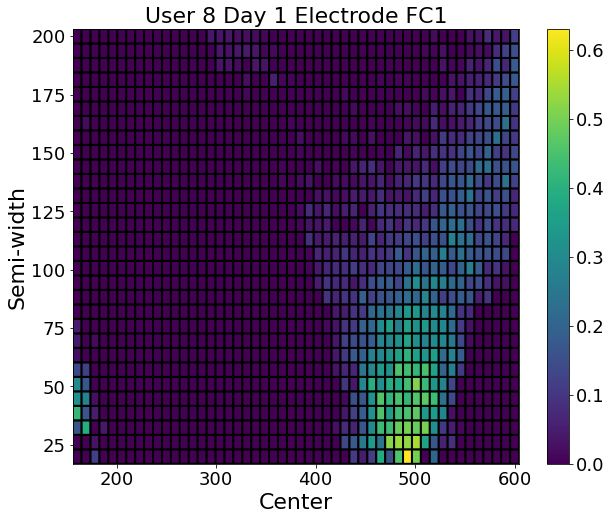

In [78]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s1[6][:][:,0] + probs_best_electrode_s2[6][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s1[6][:][:,1] + probs_best_electrode_s2[6][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s1[6][:][:,2] + probs_best_electrode_s2[6][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 8 Day 1 Electrode {best_d1_name[6][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u8/prob_bound_u8_d1_best_electrode.png')
plt.show()

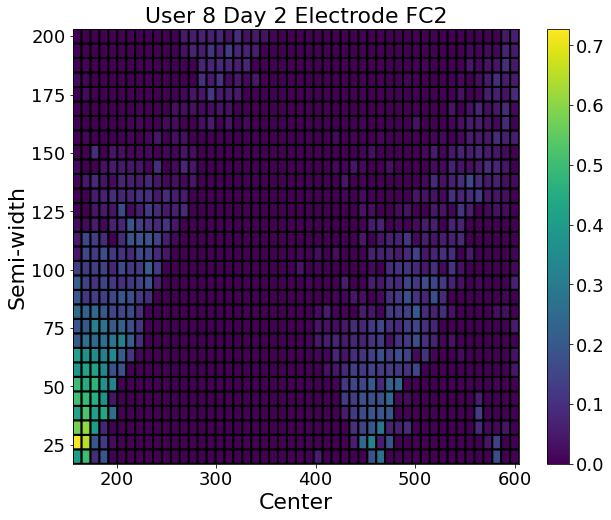

In [79]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s3[6][:][:,0] + probs_best_electrode_s4[6][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s3[6][:][:,1] + probs_best_electrode_s4[6][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s3[6][:][:,2] + probs_best_electrode_s4[6][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 8 Day 2 Electrode {best_d2_name[6][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u8/prob_bound_u8_d2_best_electrode.png')
plt.show()

##### User 9

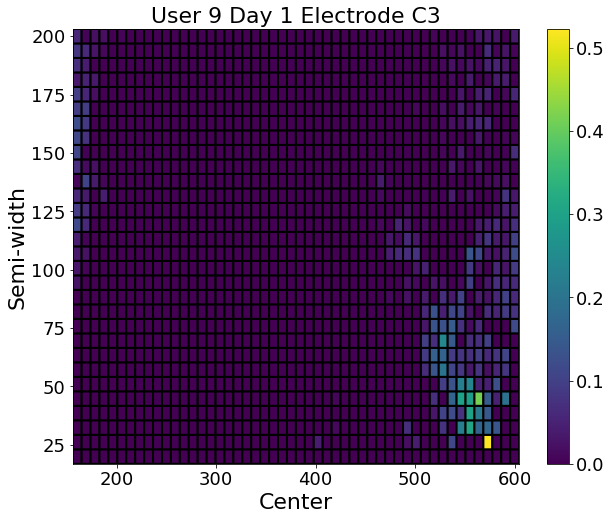

In [80]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s1[7][:][:,0] + probs_best_electrode_s2[7][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s1[7][:][:,1] + probs_best_electrode_s2[7][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s1[7][:][:,2] + probs_best_electrode_s2[7][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 9 Day 1 Electrode {best_d1_name[7][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u9/prob_bound_u9_d1_best_electrode.png')
plt.show()

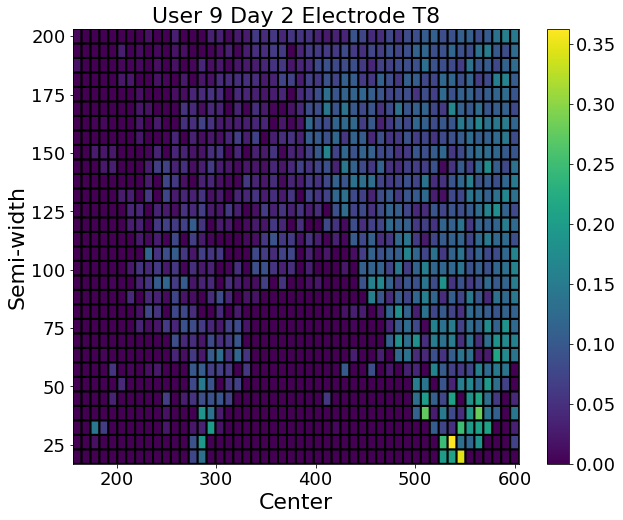

In [81]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s3[7][:][:,0] + probs_best_electrode_s4[7][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s3[7][:][:,1] + probs_best_electrode_s4[7][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s3[7][:][:,2] + probs_best_electrode_s4[7][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 9 Day 2 Electrode {best_d2_name[7][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u9/prob_bound_u9_d2_best_electrode.png')
plt.show()

## Event counting method based on minimum values

In [ ]:
def event_counter_min_method(run_eeg, run_check, center, semi_width, size):
    """
    Gets the probability of finding the maximum value of the trial inside the defined stimulus window for trials containing
    target images
    
    Args:
        run_eeg: Values of electroencefalogram of the run (n_electrodes x n_points x n_trials)
        run_check: Array n_images indicating if the image is the target the subject is thinking or not
        center: Position of the center of the stimulus window
        semi_width: Semi width of the stimulus window
        size: Number of trials desired to be taken acount in the calculations (generated via bootstrapping)
        
    Returns:
        response_prob: Array 1 x n_electodes containing the probability of finding the maximum value of the trial inside
                       the defined window i a target trial. One entry per electrode
        baseline_prob: Array 1 x n_electodes containing the probability of finding the maximum value of the trial inside
                       the defined window in a no target trial. One entry per electrode
    """
    
    mask = mask_generator(128, 700, center, semi_width)
    
    trial_counter = 0
    
    min_count_response = np.zeros(run_eeg.shape[0])
    min_count_baseline = np.zeros(run_eeg.shape[0])
    
    target_random, baseline_random = stimulus_baseline_window_obtainer(run_eeg, run_check, center, semi_width, size)
    
    for target_trial_number, baseline_trial_number in zip(target_random, baseline_random):
        
        target_trial = run_eeg[:,:len(mask), target_trial_number]
        baseline_trial = run_eeg[:,:len(mask), baseline_trial_number]
        
        window_check_response = np.array([mask[min_pos] for min_pos in np.argmin(target_trial, axis=1)])
        window_check_baseline = np.array([mask[min_pos] for min_pos in np.argmin(baseline_trial, axis=1)])
        
        min_count_response += window_check_response
        min_count_baseline += window_check_baseline
        
        trial_counter += 1
        
    response_prob = min_count_response / trial_counter
    baseline_prob = min_count_baseline / trial_counter

    return response_prob, baseline_prob

### Selecting optimal values for all users

#### Best electrode of day 1

In [ ]:
semi_widths = np.linspace(20, 200, 30)
centers = np.linspace(160, 600, 50)

data = [su_1_clean, su_2_clean, su_3_clean, su_4_clean, su_6_clean, su_7_clean, su_8_clean, su_9_clean]
probs = []

for user in data:

    lower_bound_prob_user = []

    for center in centers:
        for semi_width in semi_widths:
            
            resp_bound_sesion_1, resp_bound_sesion_2 = 0, 0
                        
            for run in user[0]:
                
                response_run, baseline_run = event_counter_min_method(run['eeg'], run['check'], center, semi_width, 500)
                
                resp_bound_run = 1 - baseline_run / response_run
                
                resp_bound_sesion_1 += resp_bound_run
                
            resp_bound_sesion_1[resp_bound_sesion_1 < 0] = 0
            resp_bound_sesion_1[~np.isfinite(resp_bound_sesion_1)] = 0                
            
            resp_bound_sesion_1 /= 6
            
            for run in user[1]:
                
                response_run, baseline_run = event_counter_min_method(run['eeg'], run['check'], center, semi_width, 500)
                
                resp_bound_run = 1 - baseline_run / response_run
                
                resp_bound_sesion_2 += resp_bound_run
                
            resp_bound_sesion_2[resp_bound_sesion_2 < 0] = 0
            resp_bound_sesion_2[~np.isfinite(resp_bound_sesion_2)] = 0 

            resp_bound_sesion_2 /= 6
            
            resp_bound_day = (resp_bound_sesion_1 + resp_bound_sesion_2) / 2

            lower_bound_prob_user.append([center, semi_width, resp_bound_day])


    probs.append(np.array(lower_bound_prob_user))

np.save('output_arrays/probs_all_subjects_all_electrodes_day_one_min_method', probs)

In [82]:
probs_day_1 = np.load('output_arrays/probs_all_subjects_all_electrodes_day_one_min_method.npy',allow_pickle=True)

In [83]:
best_electrodes_d1 = []

for user in probs_day_1:
    
    best_combinations = []

    for combination in sorted(user, key = lambda x: max(x[2]), reverse=True):

        best_combinations.append(np.argmax(combination[2]))

    best_electrodes_d1.append(best_combinations[:500])

#### Best electrode of day 2

In [ ]:
semi_widths = np.linspace(20, 200, 30)
centers = np.linspace(160, 600, 50)

data = [su_1_clean, su_2_clean, su_3_clean, su_4_clean, su_6_clean, su_7_clean, su_8_clean, su_9_clean]
probs = []

for user in data:

    lower_bound_prob_user = []

    for center in centers:
        for semi_width in semi_widths:
            
            resp_bound_sesion_3, resp_bound_sesion_4 = 0, 0
                        
            for run in user[2]:
                
                response_run, baseline_run = event_counter_min_method(run['eeg'], run['check'], center, semi_width, 500)
                
                resp_bound_run = 1 - baseline_run / response_run
                
                resp_bound_sesion_3 += resp_bound_run
                
            resp_bound_sesion_3[resp_bound_sesion_3 < 0] = 0
            resp_bound_sesion_3[~np.isfinite(resp_bound_sesion_3)] = 0    
            
            resp_bound_sesion_3 /= 6
            
            for run in user[3]:
                
                response_run, baseline_run = event_counter_min_method(run['eeg'], run['check'], center, semi_width, 500)
                
                resp_bound_run = 1 - baseline_run / response_run
                
                resp_bound_sesion_4 += resp_bound_run
                
            resp_bound_sesion_4[resp_bound_sesion_4 < 0] = 0
            resp_bound_sesion_4[~np.isfinite(resp_bound_sesion_4)] = 0    

            resp_bound_sesion_4 /= 6
            
            resp_bound_day = (resp_bound_sesion_3 + resp_bound_sesion_4) / 2

            lower_bound_prob_user.append([center, semi_width, resp_bound_day])


    probs.append(np.array(lower_bound_prob_user))

np.save('output_arrays/probs_all_subjects_all_electrodes_day_two_min_method', probs)

In [84]:
probs_day_2 = np.load('output_arrays/probs_all_subjects_all_electrodes_day_two_min_method.npy',allow_pickle=True)

In [85]:
best_electrodes_d2 = []

for user in probs_day_2:
    
    best_combinations = []

    for combination in sorted(user, key = lambda x: max(x[2]), reverse=True):

        best_combinations.append((np.argmax(combination[2])))

    best_electrodes_d2.append(best_combinations[:200])

#### Best electrode summary

In [86]:
from collections import OrderedDict 

best_d1, best_d2 = [], []
best_d1_name, best_d2_name = [], []

users = [1,2,3,4,6,7,8,9]

for user_1, user_3 in zip(best_electrodes_d1, best_electrodes_d2):
    
    result_1 = list(OrderedDict.fromkeys(user_1))[:8]
    result_3 = list(OrderedDict.fromkeys(user_3))[:8]
    
    best_d1.append([int(electrode) for electrode in result_1])
    best_d2.append([int(electrode) for electrode in result_3])
    
best_d1_name = [[electrode_list[electrode] for electrode in user] for user in best_d1]
best_d2_name = [[electrode_list[electrode] for electrode in user] for user in best_d2]

print('\n------------------- DAY 1 -------------------\n')
for user, best_electrode_list in zip(users, best_d1_name):
    print(f'The 8 bests electrodes for user {user} are {best_electrode_list}')

print('\n------------------- DAY 2 -------------------\n')
for user, best_electrode_list in zip(users, best_d2_name):
    print(f'The 8 bests electrodes for user {user} are {best_electrode_list}')


------------------- DAY 1 -------------------

The 8 bests electrodes for user 1 are ['FC6', 'AF3', 'PO3', 'P4', 'Fp1', 'PO4', 'FC2', 'CP2']
The 8 bests electrodes for user 2 are ['AF4', 'FC6', 'Cz', 'T8', 'Fp1', 'Pz', 'CP2', 'FC1']
The 8 bests electrodes for user 3 are ['FC1', 'Fz', 'PO3', 'Pz', 'FC6', 'P8', 'CP2', 'O1']
The 8 bests electrodes for user 4 are ['AF4', 'P4', 'P7', 'C3', 'CP1', 'F4', 'T7', 'F8']
The 8 bests electrodes for user 6 are ['P7', 'P3', 'C3', 'O2', 'PO3', 'P8', 'Oz', 'F8']
The 8 bests electrodes for user 7 are ['P4', 'P8', 'P3', 'F3', 'PO4', 'O1', 'PO3', 'CP2']
The 8 bests electrodes for user 8 are ['O1', 'CP5', 'Fp1', 'Fz', 'CP1', 'P4', 'F4', 'PO4']
The 8 bests electrodes for user 9 are ['O2', 'AF4', 'PO3', 'O1', 'CP5', 'FC6', 'P3', 'Fp2']

------------------- DAY 2 -------------------

The 8 bests electrodes for user 1 are ['Oz', 'CP6', 'Cz', 'FC6', 'F8', 'Pz', 'P3', 'PO4']
The 8 bests electrodes for user 2 are ['C3', 'CP2', 'P3', 'F3', 'P4', 'O1', 'Pz', 'Oz']

#### Colormaps for each user with the best electrode

In [ ]:
semi_widths = np.linspace(20, 200, 30)
centers = np.linspace(160, 600, 50)

data = [su_1_clean, su_2_clean, su_3_clean, su_4_clean, su_6_clean, su_7_clean, su_8_clean, su_9_clean]
best_electrodes = [best[0] for best in best_d1]

probs = []

for user, electrode in zip(data, best_electrodes):

    lower_bound_prob_user = []

    for center in centers:
        for semi_width in semi_widths:
            
            resp_bound_session = 0
            
            for run in user[0]:
                
                response_run, baseline_run = event_counter_max_method(run['eeg'], run['check'], center, semi_width, 300)
                
                resp_bound_run = 1 - baseline_run / response_run
                
                resp_bound_session += resp_bound_run
                
            resp_bound_session /= 6
                
            resp_bound_session[resp_bound_session < 0] = 0
            resp_bound_session[~np.isfinite(resp_bound_session)] = 0

            lower_bound_prob_user.append([center, semi_width, resp_bound_session[electrode]])


    probs.append(np.array(lower_bound_prob_user))

np.save('output_arrays/probs_all_subjects_best_electrode_session_one_min_method', probs)

In [ ]:
semi_widths = np.linspace(20, 200, 30)
centers = np.linspace(160, 600, 50)

data = [su_1_clean, su_2_clean, su_3_clean, su_4_clean, su_6_clean, su_7_clean, su_8_clean, su_9_clean]
best_electrodes = [best[0] for best in best_d1]

probs = []

for user, electrode in zip(data, best_electrodes):

    lower_bound_prob_user = []

    for center in centers:
        for semi_width in semi_widths:
            
            resp_bound_session = 0
            
            for run in user[1]:
                
                response_run, baseline_run = event_counter_max_method(run['eeg'], run['check'], center, semi_width, 300)
                
                resp_bound_run = 1 - baseline_run / response_run
                
                resp_bound_session += resp_bound_run
                
            resp_bound_session /= 6
                
            resp_bound_session[resp_bound_session < 0] = 0
            resp_bound_session[~np.isfinite(resp_bound_session)] = 0

            lower_bound_prob_user.append([center, semi_width, resp_bound_session[electrode]])


    probs.append(np.array(lower_bound_prob_user))

np.save('output_arrays/probs_all_subjects_best_electrode_session_two_min_method', probs)

In [ ]:
semi_widths = np.linspace(20, 200, 30)
centers = np.linspace(160, 600, 50)

data = [su_1_clean, su_2_clean, su_3_clean, su_4_clean, su_6_clean, su_7_clean, su_8_clean, su_9_clean]
best_electrodes = [best[0] for best in best_d2]

probs = []

for user, electrode in zip(data, best_electrodes):

    lower_bound_prob_user = []

    for center in centers:
        for semi_width in semi_widths:
            
            resp_bound_session = 0
            
            for run in user[2]:
                
                response_run, baseline_run = event_counter_max_method(run['eeg'], run['check'], center, semi_width, 300)
                
                resp_bound_run = 1 - baseline_run / response_run
                
                resp_bound_session += resp_bound_run
                
            resp_bound_session /= 6
                
            resp_bound_session[resp_bound_session < 0] = 0
            resp_bound_session[~np.isfinite(resp_bound_session)] = 0

            lower_bound_prob_user.append([center, semi_width, resp_bound_session[electrode]])


    probs.append(np.array(lower_bound_prob_user))


np.save('output_arrays/probs_all_subjects_best_electrode_session_three_min_method', probs)

In [ ]:
semi_widths = np.linspace(20, 200, 30)
centers = np.linspace(160, 600, 50)

data = [su_1_clean, su_2_clean, su_3_clean, su_4_clean, su_6_clean, su_7_clean, su_8_clean, su_9_clean]
best_electrodes = [best[0] for best in best_d2]

probs = []

for user, electrode in zip(data, best_electrodes):

    lower_bound_prob_user = []

    for center in centers:
        for semi_width in semi_widths:
            
            resp_bound_session = 0
            
            for run in user[3]:
                
                response_run, baseline_run = event_counter_max_method(run['eeg'], run['check'], center, semi_width, 300)
                
                resp_bound_run = 1 - baseline_run / response_run
                
                resp_bound_session += resp_bound_run
                
            resp_bound_session /= 6
                
            resp_bound_session[resp_bound_session < 0] = 0
            resp_bound_session[~np.isfinite(resp_bound_session)] = 0

            lower_bound_prob_user.append([center, semi_width, resp_bound_session[electrode]])


    probs.append(np.array(lower_bound_prob_user))


np.save('output_arrays/probs_all_subjects_best_electrode_session_four_min_method', probs)

In [87]:
probs_best_electrode_s1 = np.load('output_arrays/probs_all_subjects_best_electrode_session_one_min_method.npy', allow_pickle=True)
probs_best_electrode_s2 = np.load('output_arrays/probs_all_subjects_best_electrode_session_two_min_method.npy', allow_pickle=True)
probs_best_electrode_s3 = np.load('output_arrays/probs_all_subjects_best_electrode_session_three_min_method.npy', allow_pickle=True)
probs_best_electrode_s4 = np.load('output_arrays/probs_all_subjects_best_electrode_session_four_min_method.npy', allow_pickle=True)

##### User 1

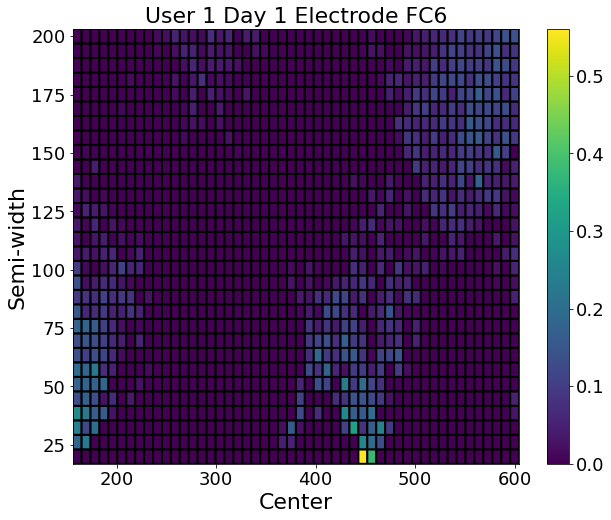

In [88]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s1[0][:][:,0] + probs_best_electrode_s2[0][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s1[0][:][:,1] + probs_best_electrode_s2[0][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s1[0][:][:,2] + probs_best_electrode_s2[0][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 1 Day 1 Electrode {best_d1_name[0][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u1/prob_bound_u1_d1_best_electrode_min.png')
plt.show()

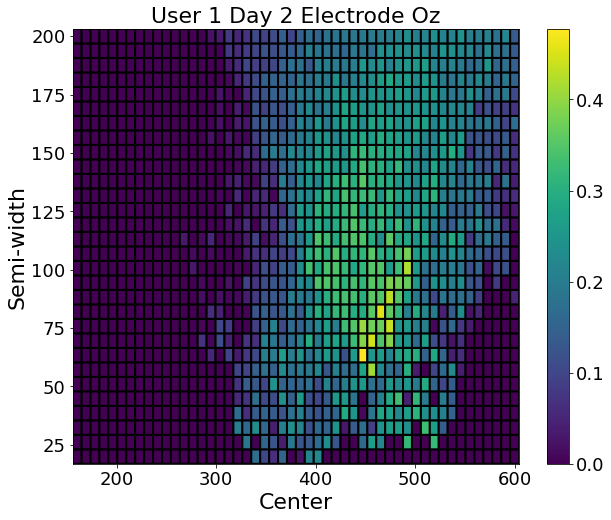

In [89]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s3[0][:][:,0] + probs_best_electrode_s4[0][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s3[0][:][:,1] + probs_best_electrode_s4[0][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s3[0][:][:,2] + probs_best_electrode_s4[0][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 1 Day 2 Electrode {best_d2_name[0][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u1/prob_bound_u1_d2_best_electrode_min.png')
plt.show()

##### User 2

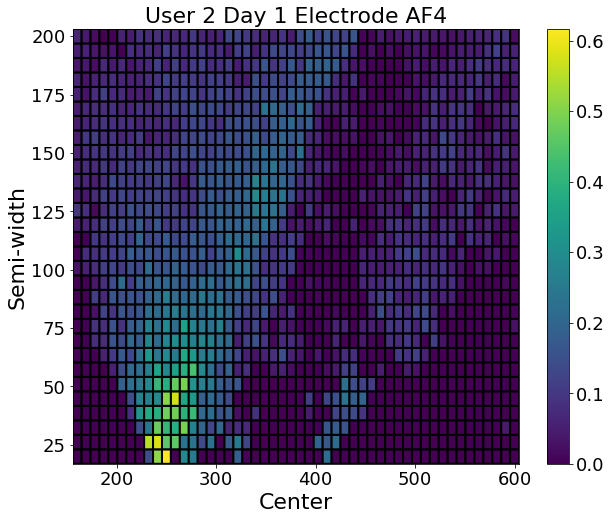

In [90]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s1[1][:][:,0] + probs_best_electrode_s2[1][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s1[1][:][:,1] + probs_best_electrode_s2[1][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s1[1][:][:,2] + probs_best_electrode_s2[1][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 2 Day 1 Electrode {best_d1_name[1][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u2/prob_bound_u2_d1_best_electrode_min.png')
plt.show()

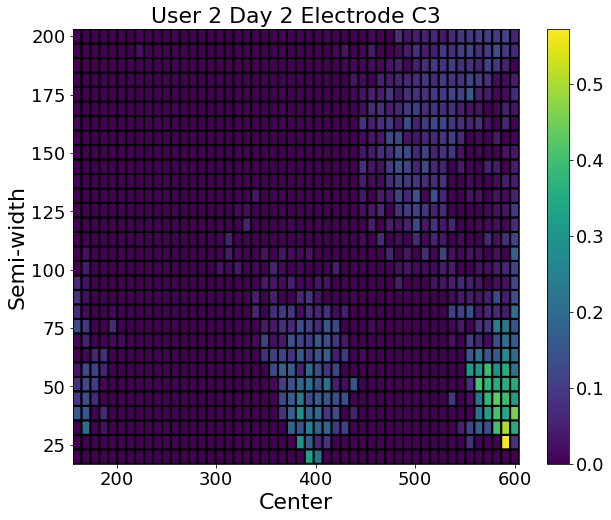

In [91]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s3[1][:][:,0] + probs_best_electrode_s4[1][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s3[1][:][:,1] + probs_best_electrode_s4[1][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s3[1][:][:,2] + probs_best_electrode_s4[1][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 2 Day 2 Electrode {best_d2_name[1][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u2/prob_bound_u2_d2_best_electrode_min.png')
plt.show()

##### User 3

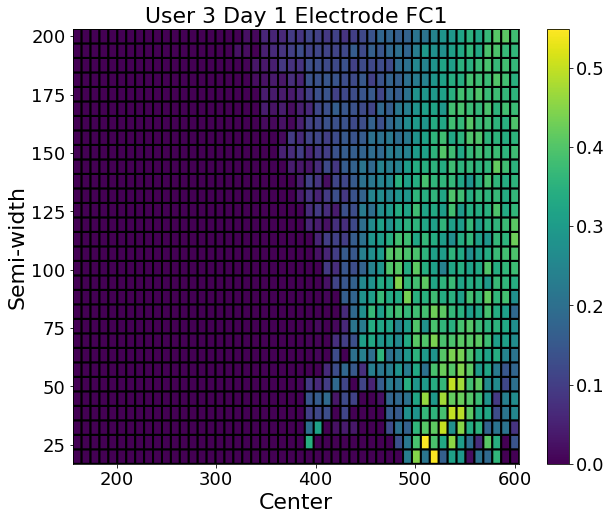

In [92]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s1[2][:][:,0] + probs_best_electrode_s2[2][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s1[2][:][:,1] + probs_best_electrode_s2[2][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s1[2][:][:,2] + probs_best_electrode_s2[2][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 3 Day 1 Electrode {best_d1_name[2][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u3/prob_bound_u3_d1_best_electrode_min.png')
plt.show()

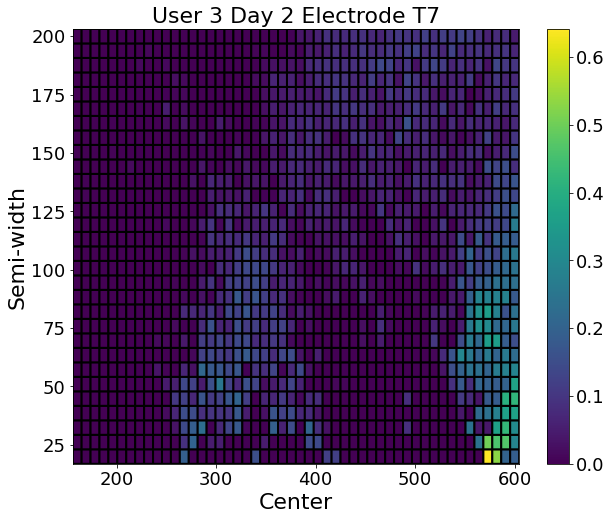

In [93]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s3[2][:][:,0] + probs_best_electrode_s4[2][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s3[2][:][:,1] + probs_best_electrode_s4[2][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s3[2][:][:,2] + probs_best_electrode_s4[2][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 3 Day 2 Electrode {best_d2_name[2][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u3/prob_bound_u3_d2_best_electrode_min.png')
plt.show()

##### User 4

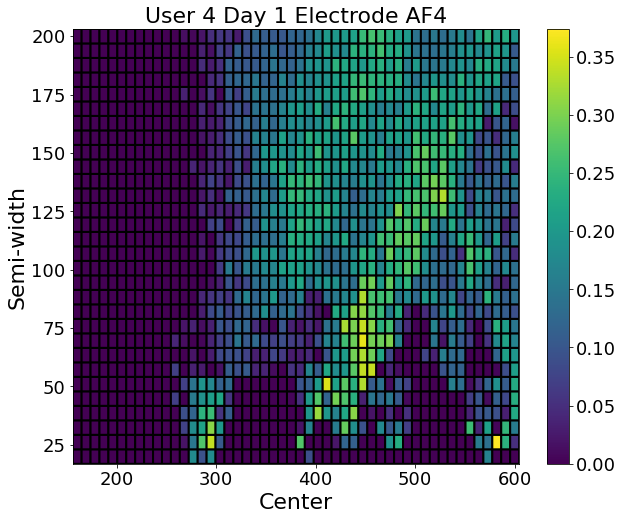

In [94]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s1[3][:][:,0] + probs_best_electrode_s2[3][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s1[3][:][:,1] + probs_best_electrode_s2[3][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s1[3][:][:,2] + probs_best_electrode_s2[3][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 4 Day 1 Electrode {best_d1_name[3][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u4/prob_bound_u4_d1_best_electrode_min.png')
plt.show()

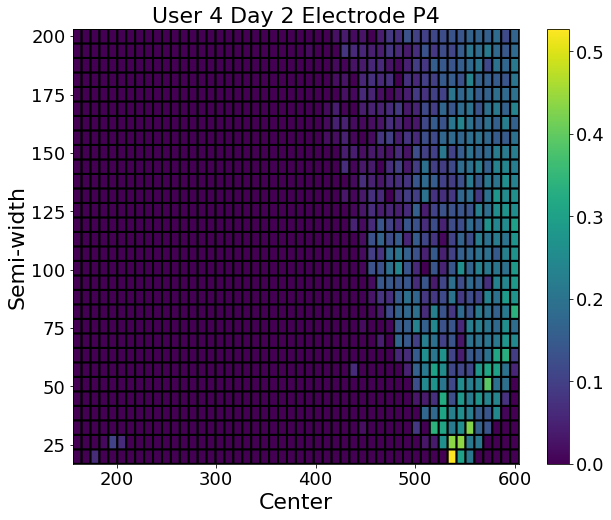

In [95]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s3[3][:][:,0] + probs_best_electrode_s4[3][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s3[3][:][:,1] + probs_best_electrode_s4[3][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s3[3][:][:,2] + probs_best_electrode_s4[3][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 4 Day 2 Electrode {best_d2_name[3][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u4/prob_bound_u4_d2_best_electrode_min.png')
plt.show()

##### User 6

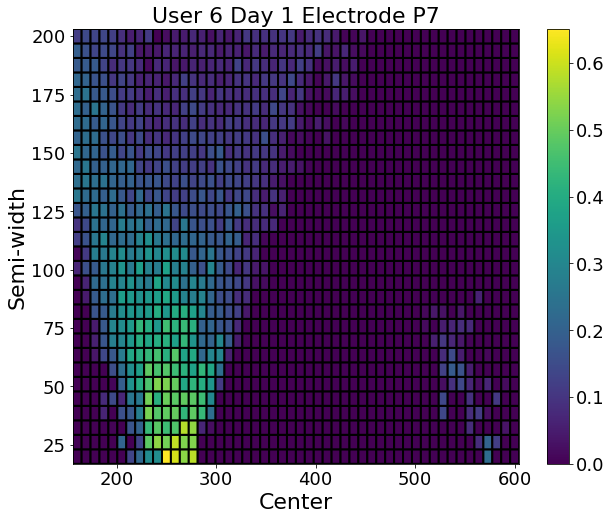

In [96]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s1[4][:][:,0] + probs_best_electrode_s2[4][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s1[4][:][:,1] + probs_best_electrode_s2[4][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s1[4][:][:,2] + probs_best_electrode_s2[4][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 6 Day 1 Electrode {best_d1_name[4][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u6/prob_bound_u6_d1_best_electrode_min.png')
plt.show()

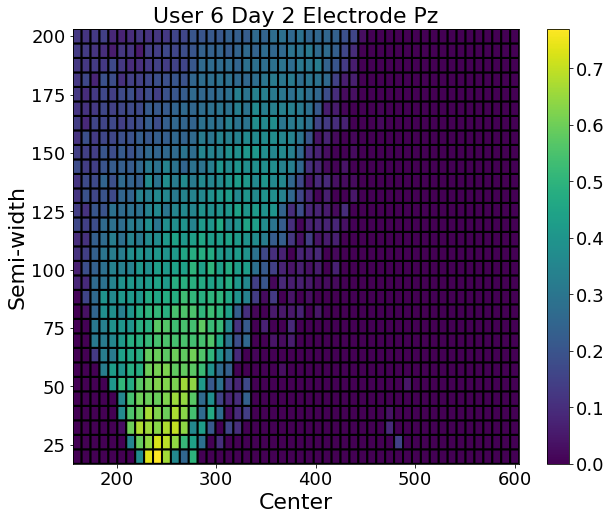

In [97]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s3[4][:][:,0] + probs_best_electrode_s4[4][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s3[4][:][:,1] + probs_best_electrode_s4[4][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s3[4][:][:,2] + probs_best_electrode_s4[4][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 6 Day 2 Electrode {best_d2_name[4][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u6/prob_bound_u6_d2_best_electrode_min.png')
plt.show()

##### User 7

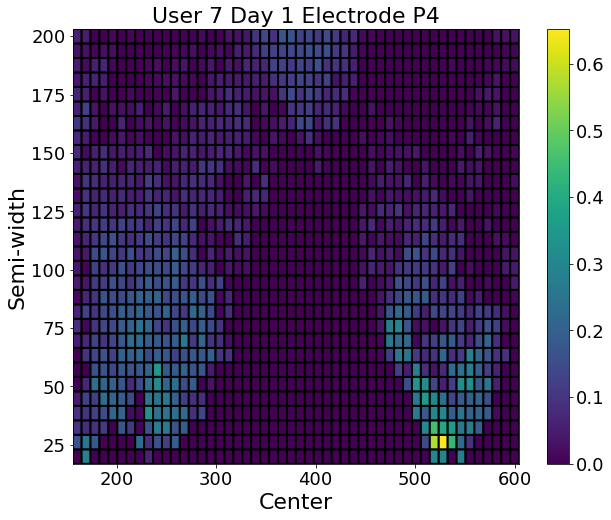

In [98]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s1[5][:][:,0] + probs_best_electrode_s2[5][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s1[5][:][:,1] + probs_best_electrode_s2[5][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s1[5][:][:,2] + probs_best_electrode_s2[5][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 7 Day 1 Electrode {best_d1_name[5][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u7/prob_bound_u7_d1_best_electrode_min.png')
plt.show()

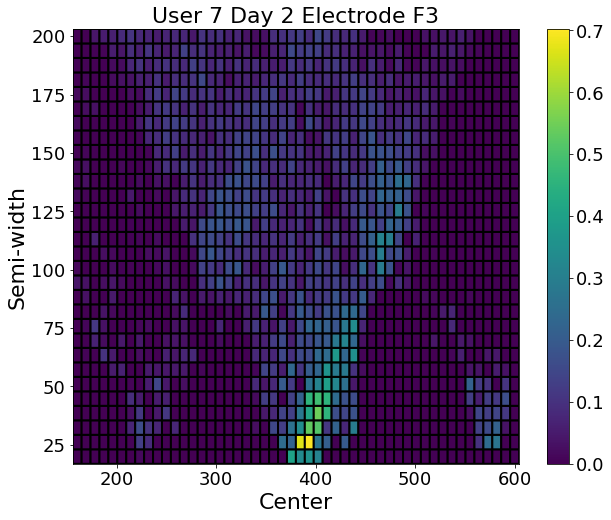

In [99]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s3[5][:][:,0] + probs_best_electrode_s4[5][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s3[5][:][:,1] + probs_best_electrode_s4[5][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s3[5][:][:,2] + probs_best_electrode_s4[5][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 7 Day 2 Electrode {best_d2_name[5][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u7/prob_bound_u7_d2_best_electrode_min.png')
plt.show()

##### User 8

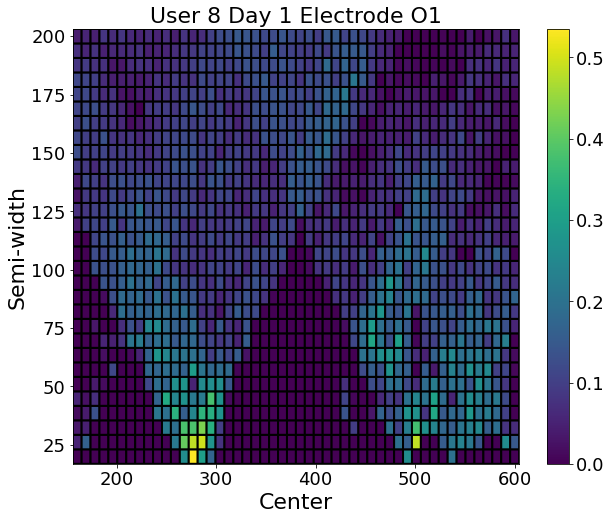

In [100]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s1[6][:][:,0] + probs_best_electrode_s2[6][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s1[6][:][:,1] + probs_best_electrode_s2[6][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s1[6][:][:,2] + probs_best_electrode_s2[6][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 8 Day 1 Electrode {best_d1_name[6][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u8/prob_bound_u8_d1_best_electrode_min.png')
plt.show()

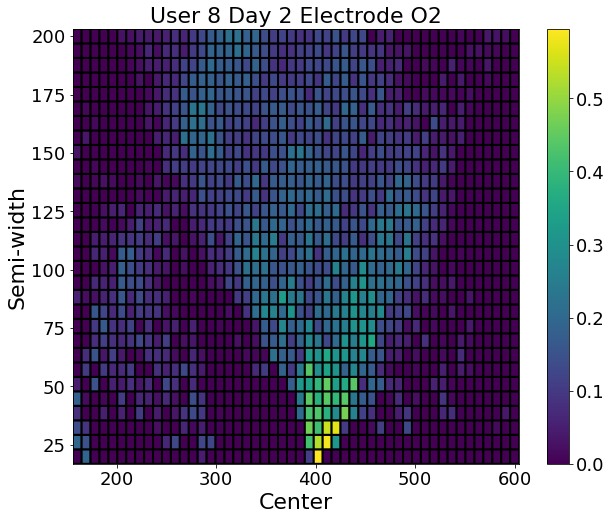

In [101]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s3[6][:][:,0] + probs_best_electrode_s4[6][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s3[6][:][:,1] + probs_best_electrode_s4[6][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s3[6][:][:,2] + probs_best_electrode_s4[6][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 8 Day 2 Electrode {best_d2_name[6][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u8/prob_bound_u8_d2_best_electrode_min.png')
plt.show()

##### User 9

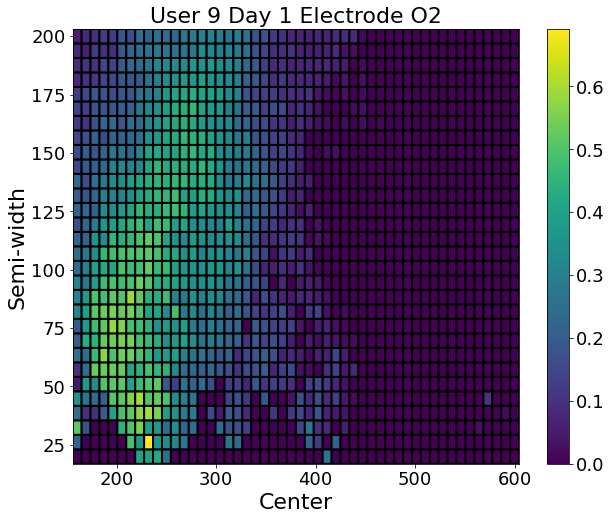

In [102]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s1[7][:][:,0] + probs_best_electrode_s2[7][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s1[7][:][:,1] + probs_best_electrode_s2[7][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s1[7][:][:,2] + probs_best_electrode_s2[7][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 9 Day 1 Electrode {best_d1_name[7][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u9/prob_bound_u9_d1_best_electrode_min.png')
plt.show()

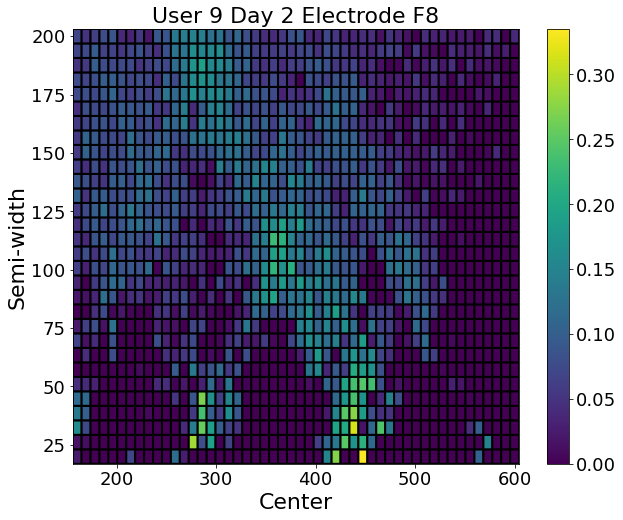

In [103]:
fig, ax = plt.subplots(figsize=(10,8))

font = {'size': 22}

center     = (probs_best_electrode_s3[7][:][:,0] + probs_best_electrode_s4[7][:][:,0] ) / 2
semiwidth  = (probs_best_electrode_s3[7][:][:,1] + probs_best_electrode_s4[7][:][:,1] ) / 2
prob_bound = (probs_best_electrode_s3[7][:][:,2] + probs_best_electrode_s4[7][:][:,2] ) / 2

X, Y = np.reshape(center,(50,30)), np.reshape(semiwidth,(50,30))
Z = np.reshape(prob_bound,(50,30))

cf0 = plt.pcolor(X, Y, Z, edgecolors='k', linewidths=2, shading='auto')
cbar = fig.colorbar(cf0)

ax.set_xlabel('Center', fontdict=font)
ax.set_ylabel('Semi-width', fontdict=font)
ax.set_title(f'User 9 Day 2 Electrode {best_d2_name[7][0]}', fontdict=font)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('images/bounds/u9/prob_bound_u9_d2_best_electrode_min.png')
plt.show()